In [1]:
#!pip install tensorflow==1.13.1
#!pip install keras 2.2.4

In [1]:
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
#import pymatgen

from matplotlib import pyplot as plt

import tensorflow as tf
import keras
#from keras import backend as K
from tensorflow.keras import backend as K
from keras import initializers
from keras.layers import Dense, Input, Activation, multiply
from keras.models import Sequential, Model, load_model
from keras.layers.merge import add, concatenate

#import deepchem as dc


/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/apps/share64/debian7/ana

In [24]:
act_dict = {0: 'linear', 1: 'multiply', 2: 'sqrt', 3: '4rt'}
np.random.seed(100000)
#np.random.seed(200000)
weight_dict = {0: 0, 1: 1, 2: np.random.uniform(0.0,1.0,1)[0], 3: 0}
bias_dict = {0: 0, 1: 1, 2: np.random.uniform(0.0,0.001,1)[0]}
nact_terms = 5
nweight_terms = 20
nbias_terms = 5

print(bias_dict)

{0: 0, 1: 1, 2: 0.0005082481908477833}


In [25]:
df = pd.read_csv('CHNO_data.csv')
#df = pd.read_csv('ExpData_v2.csv')
#df = pd.read_excel('ExpData.xlsx')
print (df.shape)

(149, 21)


In [26]:
df = df.round({'N_arb': 6, 'M_arb': 3, 'Q_arb': 3, 'Density [g/cc]': 3, 'D (exp) [km/s]': 3})
#df['D_KJ [km/s]'] = np.around(1.01*np.sqrt(df['N_arb']*np.sqrt(df['M_arb'])*np.sqrt(df['Q_arb']))*(1+1.3*df['Density [g/cc]']),decimals=3)
df

,Explosive,C,H,N,O,Al,B,Ba,Ca,Cl,...,P,Pb,Si,Heat of Formation [kcal/mol],Density [g/cc],D (exp) [km/s],N_arb,M_arb,Q_arb,D_KJ
0,"1,3,5-Triamino-2,4,6-trinitrobenzene",6.000,6.000,6.000,6.000,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-33.398140,1.800,7.350,0.029070,27.200,1089.154,7.545764
1,"1,3,5-Trinitrobenzene",6.000,3.000,3.000,6.000,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-10.399280,1.710,7.300,0.024648,32.000,1351.177,7.369484
2,"2,4,6,2',4',6'-Hexanitrodiphenylamine",12.000,5.000,7.000,12.000,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,9.882000,1.600,7.200,0.024487,32.744,1368.752,7.082862
3,"2,4,6-Trinitrocresol",7.000,5.000,3.000,7.000,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-60.288800,1.620,6.850,0.025720,29.760,1216.919,6.940381
4,"3-Nitro-1,2,4-triazole-5-one",2.000,2.000,4.000,3.000,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-24.086714,1.800,7.890,0.030769,29.500,982.410,7.720667
5,ABH,24.000,6.000,14.000,24.000,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,116.000000,1.640,7.200,0.023455,34.732,1460.412,7.270507
6,AMATEX-20 [21/41/38] [AN/RDX/TNT],3.890,5.200,4.020,5.370,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-18.030000,1.660,7.550,0.030889,27.359,1352.226,7.774580
7,AMATEX-40 [42/20/38] [AN/RDX/TNT],3.260,4.780,3.180,4.740,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-39.470000,1.610,7.010,0.031383,27.011,1273.116,7.536167
8,AMATOL-60/40 [AN/TNT],2.800,4.400,2.400,4.200,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-58.440000,1.600,5.760,0.031700,26.636,1172.334,7.362669
9,AMATOL-80/20 [AN/TNT],1.400,4.200,2.200,3.600,0.0,0,0.0,0.0,0.0,...,0.0,0,0.0,-72.920000,1.600,5.200,0.036106,25.722,1087.386,7.644200


In [27]:
inputs = np.array(df[['N_arb','M_arb','Q_arb','Density [g/cc]']])

outputs = np.array(df['D (exp) [km/s]'])
len(outputs)
#Train_inputs, Test_inputs, Train_outputs, Test_outputs = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

149

In [28]:

def sqrt_act(x):
    return np.abs(x)**(1/2)

def frt_act(x):
    return np.abs(x)**(1/4)



In [29]:
class CustomDense(keras.layers.Layer):
    def __init__(self, num_units, input_num, activation, name, trainable_weight, trainable_bias):
        super(CustomDense, self).__init__()
        self.num_units = num_units
        self.activation = Activation(activation)
        self.trainable_weight = trainable_weight
        self.trainable_bias = trainable_bias
        self.name = name
        name_w = 'w'+self.name[1:]
        name_b = 'b'+self.name[1:]
        self.weight = self.add_weight(shape=(input_num, self.num_units), name=name_w, trainable=self.trainable_weight, initializer="zeros")
        self.bias = self.add_weight(shape=(self.num_units,), name=name_b, trainable=self.trainable_bias, initializer="zeros")
        
    def call(self, input):
        y = tf.matmul(input, self.weight) + self.bias
        y = self.activation(y)
        return y


In [30]:
def create_node(input1, input2, input3, input4, name, trainable1, trainable2, trainable3, trainable4, act, bias):
    base = name
    n1 = base + "1"
    n2 = base + "2"
    n3 = base + "3"
    n4 = base + "4"
    an1 = CustomDense(1, 1, activation = 'linear', name=n1, trainable_weight=trainable1, trainable_bias = 0) (input1)
    an2 = CustomDense(1, 1, activation = 'linear', name=n2, trainable_weight=trainable2, trainable_bias = 0) (input2)
    an3 = CustomDense(1, 1, activation = 'linear', name=n3, trainable_weight=trainable3, trainable_bias = 0) (input3)
    an4 = CustomDense(1, 1, activation = 'linear', name=n4, trainable_weight=trainable4, trainable_bias=bias) (input4)
    if (act == "multiply"):
        an = multiply([an1, an2, an3, an4])
    
    else:
        an = add([an1, an2, an3, an4])
        if (act == "4rt"):
            an = Activation(frt_act) (an)
        elif (act == "sqrt"):
            an = Activation(sqrt_act) (an)
        else:
            an = Activation(act) (an)
    return an

In [31]:
def create_model(x):
    #initializer = keras.initializers.RandomUniform(minval=-0.001, maxval=0.001, seed=0)
    bias_initial = keras.initializers.Zeros()

    trainable_list = []
    for i in range(nweight_terms):
        if (x[i+nact_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)
    
    for i in range(nbias_terms):
        if (x[i+nact_terms+nweight_terms] == 2):
            trainable_list.append(True)
        else:
            trainable_list.append(False)

    input1 = Input(shape=(1,))
    input2 = Input(shape=(1,))
    input3 = Input(shape=(1,))
    input4 = Input(shape=(1,))

    a1 = create_node(input1, input2, input3, input4, "a1", trainable_list[0], trainable_list[1], trainable_list[2], trainable_list[3], act_dict[x[0]], trainable_list[20])
    a2 = create_node(input1, input2, input3, input4, "a2", trainable_list[4], trainable_list[5], trainable_list[6], trainable_list[7], act_dict[x[1]], trainable_list[21])
    a3 = create_node(input1, input2, input3, input4, "a3", trainable_list[8], trainable_list[9], trainable_list[10], trainable_list[11], act_dict[x[2]], trainable_list[22])
    a4 = create_node(input1, input2, input3, input4, "a4", trainable_list[12], trainable_list[13], trainable_list[14], trainable_list[15], act_dict[x[3]], trainable_list[23])

    output = create_node(a1, a2, a3, a4, "output", trainable_list[16], trainable_list[17], trainable_list[18], trainable_list[19], act_dict[x[4]], trainable_list[24])
   

    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-2)
    model.compile(loss='mse', optimizer=optimizer)
    
    layer_list = []
    for i in range(len(model.layers)):
        name = model.layers[i].name
        if ( ("activation" in name) or ("input" in name) or ("add" in name) or ("multiply" in name) ):
            continue
        else:
            layer_list.append(i)
    
    for i in range(len(layer_list)):
                
        #if (model.layers[layer_list[i]].get_weights()[0].shape==(1,1)):
         #   model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ),  np.array( [ bias_dict[x[nact_terms+nweight_terms+i]] ] ) ] )
        #else:
         #   model.layers[layer_list[i]].set_weights( [ np.array( [ bias_dict[x[nact_terms+nweight_terms+i]] ] ),  np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
        
        name = model.layers[layer_list[i]].name
        if (("a14" in name) or ("a24" in name) or ("a34" in name) or ("a44" in name) or ("output4" in name)):
        
            if (model.layers[layer_list[i]].get_weights()[0].shape==(1,1)):
                model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ),  np.array( [ bias_dict[x[nact_terms+nweight_terms+int((i+1)/5)]] ] ) ] )
            else:
                model.layers[layer_list[i]].set_weights( [ np.array( [ bias_dict[x[nact_terms+nweight_terms+int((i+1)/5)]] ] ),  np.array( [[ weight_dict[x[nact_terms+i]] ]] ) ] )
            
        else:
            model.layers[layer_list[i]].set_weights( [ np.array( [[ weight_dict[x[nact_terms+i]] ]] ), np.array( [0.] ) ] )

    #model.summary()

    return model, trainable_list

In [32]:
losses = []
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + ' Loss: ' + str(logs.get('loss')) + '                     \n')
        losses.append(logs.get('loss'))
        
class ValidLossNaN(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if np.isnan(logs.get('loss')):
            self.model.stop_training=True


def train(model, train_inputs, train_outputs, verbose=False):
    mae_es= keras.callbacks.EarlyStopping(monitor='val_loss', patience=500,
                                          min_delta=1e-4, verbose=1, mode='auto', restore_best_weights=True)
    
    terminate = keras.callbacks.TerminateOnNaN()


    EPOCHS = 10000 # Number of EPOCHS
    history = model.fit([train_inputs[:,0], train_inputs[:,1], train_inputs[:,2], train_inputs[:,3]], train_outputs, epochs=EPOCHS,
                        shuffle=False, batch_size=len(train_inputs), verbose = True, callbacks=[terminate, mae_es, ValidLossNaN()],
                        validation_split=0.2)

    if verbose:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Sq Error')
        plt.plot(history.epoch, np.array(history.history['loss']),label='Training loss')
        plt.legend()
        plt.show()
    return history

In [33]:
def cv_error(individual, inputs, outputs):
    kf = KFold(n_splits=10, shuffle=True, random_state = 42)
    kf.get_n_splits(inputs)

    
    
    
    cv_mse_list = []
    train_preds_list = []
    test_preds_list = []
    train_outputs_list = []
    test_outputs_list = []
    

    for train_index, test_index in kf.split(inputs):
        #print(train_index, test_index)
        new_model, trainable = create_model(individual)
        
        train_inputs, test_inputs = inputs[train_index], inputs[test_index]
        train_outputs, test_outputs = outputs[train_index], outputs[test_index]
        
        if (any(trainable) == True):
    
            train(new_model, train_inputs, train_outputs, verbose=False)

            wt_bs = new_model.get_weights()
            weight_list = []
            bias_list = []

            for weight in wt_bs:
                if (weight.shape == (1,1)):
                    weight_list.append(weight[0])
                else:
                    bias_list.append(weight[0])
                

                #handle nan weights
            if (np.isnan(weight_list).any()):
                cv_mse = 1e50
            elif (np.isnan(np.array(bias_list)).any()):
                cv_mse = 1e50
            else:
                cv_mse = new_model.evaluate([test_inputs[:,0],test_inputs[:,1],test_inputs[:,2],test_inputs[:,3]], test_outputs)
                test_preds = np.around(new_model.predict([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3]]),decimals=3)
                train_preds = np.around(new_model.predict([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3]]),decimals=3)
                

                if (np.isnan(cv_mse)):
                    cv_mse = 1e50
                else:
                    cv_mse = np.around(cv_mse,decimals=6)

            cv_mse_list.append(cv_mse)
            train_preds_list.append(train_preds)
            test_preds_list.append(test_preds)
            train_outputs_list.append(train_outputs)
            test_outputs_list.append(test_outputs)
        
        else:
            wt_bs = new_model.get_weights()
            weight_list = []
            bias_list = []

            for weight in wt_bs:
                if (weight.shape == (1,1)):
                    weight_list.append(weight[0])
                else:
                    bias_list.append(weight[0])

            if (np.isnan(np.array(weight_list)).any()):
                cv_mse=1e50
            elif (np.isnan(np.array(bias_list)).any()):
                cv_mse = 1e50

            else:
                cv_mse = new_model.evaluate([test_inputs[:,0],test_inputs[:,1],test_inputs[:,2],test_inputs[:,3]], test_outputs)

                if (np.isnan(cv_mse)):
                    cv_mse = 1e50
                else:
                    cv_mse = np.around(cv_mse,decimals=6)

            cv_mse_list.append(cv_mse)
        
        
        
    print(cv_mse_list)
    return np.mean(cv_mse_list), train_preds_list, test_preds_list, train_outputs_list, test_outputs_list

In [34]:
def f3(w):
    return w

In [35]:
#individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0]  # kj
individual = [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0]

### KFOLDS : 152###

#individual = [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0] # p.1

#individual = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1] # p.05

#individual = [0, 0, 1, 3, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0] # p.01

#individual = [2, 0, 1, 3, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1] # p.005

#individual = [0, 0, 3, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 2, 2, 1, 2, 1, 0, 1, 0, 1] # p.001

#individual = [2, 0, 3, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 0, 1] # p.0005

#individual = [2, 0, 3, 0, 1, 2, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1]  # p.0001


### KFOLDS : 190 ###

#individual = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  # p.5

#individual = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0]  # p.1
#individual = [0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2] # p.01

In [ ]:
#### Train Converged PNN with all 152 data points and evaluate with new 37 unseen data points ####

#### TRAIN ####
new_model, trainable = create_model(individual)
train(new_model, Train_inputs, Train_outputs, verbose=True)
train_full_mse = new_model.evaluate([Train_inputs[:,0],Train_inputs[:,1],Train_inputs[:,2],Train_inputs[:,3]], Train_outputs)
train_full_preds = np.around(new_model.predict([Train_inputs[:, 0], Train_inputs[:, 1], Train_inputs[:, 2], Train_inputs[:, 3]]),decimals=3)

#### TEST ####
TEST_mse = new_model.evaluate([Test_inputs[:,0],Test_inputs[:,1],Test_inputs[:,2],Test_inputs[:,3]], Test_outputs)
TEST_preds = np.around(new_model.predict([Test_inputs[:, 0], Test_inputs[:, 1], Test_inputs[:, 2], Test_inputs[:, 3]]),decimals=3)
  


In [ ]:
#### Parity Plot ####
plt.plot(Train_outputs, train_full_preds, 'o', label='Train')
plt.plot(Test_outputs, TEST_preds, 'o', label='Test')

plt.xlabel('Experimental [km/s]', fontsize=20)
plt.ylabel('Predicted [km/s]', fontsize=20)
plt.title('Parity Plot', fontsize=24)

x = np.linspace(1, 10, 500)
plt.plot(x, x)
plt.ylim(1.0,10)
plt.xlim(1.0,10)

plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

print('Train MSE:',train_full_mse,'Train RMSE:',np.sqrt(train_full_mse))
print('Test MSE:',TEST_mse,'Test RMSE:',np.sqrt(TEST_mse))

plt.legend()
plt.grid()

In [ ]:
train_full_mse = new_model.evaluate([inputs[:,0],inputs[:,1],inputs[:,2],inputs[:,3]], outputs)
unseen_mse = new_model.evaluate([unseen_inputs[:,0],unseen_inputs[:,1],unseen_inputs[:,2],unseen_inputs[:,3]], unseen_outputs)

In [36]:
mse_term, train_preds_list, test_preds_list, train_outputs_list, test_outputs_list = cv_error(individual, inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 107 samples, validate on 27 samples
Epoch 1/10000
107/107 [==============================] - 1s 5ms/step - loss: 39.1295 - val_loss: 33.3389
Epoch 2/10000
107/107 [==============================] - 0s 38us/step - loss: 38.3513 - val_loss: 32.6751
Epoch 3/10000
107/107 [==============================] - 0s 48us/step - loss: 37.5812 - val_loss: 32.0183
Epoch 4/10000
107/107 [==============================] - 0s 23us/step - loss: 36.8194 - val_loss: 31.3685
Epoch 5/10000
107/107 [==============================] - 0s 36us/step - loss: 36.0658 - val_loss: 30.7260
Epoch 6/10000
107/107 [==============================] - 0s 62us/step - loss: 35.3208 - val_loss: 30.0908
Epoch 7/10000
107/107 [==============================] - 0s 46us/step - loss: 34.5843 - val_loss: 29.4630
Epoch 8/10000
107/107 [==============================] - 0s 39us/step - loss: 33.8566 - val_lo

Epoch 72/10000
107/107 [==============================] - 0s 56us/step - loss: 5.9234 - val_loss: 5.0425
Epoch 73/10000
107/107 [==============================] - 0s 45us/step - loss: 5.7324 - val_loss: 4.8787
Epoch 74/10000
107/107 [==============================] - 0s 45us/step - loss: 5.5467 - val_loss: 4.7194
Epoch 75/10000
107/107 [==============================] - 0s 23us/step - loss: 5.3663 - val_loss: 4.5644
Epoch 76/10000
107/107 [==============================] - 0s 72us/step - loss: 5.1910 - val_loss: 4.4139
Epoch 77/10000
107/107 [==============================] - 0s 38us/step - loss: 5.0206 - val_loss: 4.2675
Epoch 78/10000
107/107 [==============================] - 0s 38us/step - loss: 4.8552 - val_loss: 4.1253
Epoch 79/10000
107/107 [==============================] - 0s 43us/step - loss: 4.6946 - val_loss: 3.9871
Epoch 80/10000
107/107 [==============================] - 0s 45us/step - loss: 4.5387 - val_loss: 3.8529
Epoch 81/10000
107/107 [==============================]

Epoch 150/10000
107/107 [==============================] - 0s 37us/step - loss: 0.4669 - val_loss: 0.2699
Epoch 151/10000
107/107 [==============================] - 0s 35us/step - loss: 0.4570 - val_loss: 0.2602
Epoch 152/10000
107/107 [==============================] - 0s 24us/step - loss: 0.4475 - val_loss: 0.2508
Epoch 153/10000
107/107 [==============================] - 0s 46us/step - loss: 0.4385 - val_loss: 0.2419
Epoch 154/10000
107/107 [==============================] - 0s 38us/step - loss: 0.4300 - val_loss: 0.2334
Epoch 155/10000
107/107 [==============================] - 0s 25us/step - loss: 0.4218 - val_loss: 0.2252
Epoch 156/10000
107/107 [==============================] - 0s 36us/step - loss: 0.4140 - val_loss: 0.2174
Epoch 157/10000
107/107 [==============================] - 0s 34us/step - loss: 0.4067 - val_loss: 0.2099
Epoch 158/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3996 - val_loss: 0.2028
Epoch 159/10000
107/107 [=====================

Epoch 228/10000
107/107 [==============================] - 0s 32us/step - loss: 0.2763 - val_loss: 0.0571
Epoch 229/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2762 - val_loss: 0.0569
Epoch 230/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2760 - val_loss: 0.0566
Epoch 231/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2759 - val_loss: 0.0563
Epoch 232/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2758 - val_loss: 0.0561
Epoch 233/10000
107/107 [==============================] - 0s 41us/step - loss: 0.2757 - val_loss: 0.0558
Epoch 234/10000
107/107 [==============================] - 0s 47us/step - loss: 0.2756 - val_loss: 0.0556
Epoch 235/10000
107/107 [==============================] - 0s 57us/step - loss: 0.2756 - val_loss: 0.0554
Epoch 236/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2755 - val_loss: 0.0552
Epoch 237/10000
107/107 [=====================

Epoch 306/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2724 - val_loss: 0.0503
Epoch 307/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2724 - val_loss: 0.0502
Epoch 308/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2723 - val_loss: 0.0502
Epoch 309/10000
107/107 [==============================] - 0s 46us/step - loss: 0.2723 - val_loss: 0.0502
Epoch 310/10000
107/107 [==============================] - 0s 61us/step - loss: 0.2723 - val_loss: 0.0502
Epoch 311/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2722 - val_loss: 0.0502
Epoch 312/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2722 - val_loss: 0.0501
Epoch 313/10000
107/107 [==============================] - 0s 46us/step - loss: 0.2721 - val_loss: 0.0501
Epoch 314/10000
107/107 [==============================] - 0s 72us/step - loss: 0.2721 - val_loss: 0.0501
Epoch 315/10000
107/107 [=====================

Epoch 384/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2694 - val_loss: 0.0492
Epoch 385/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2694 - val_loss: 0.0492
Epoch 386/10000
107/107 [==============================] - 0s 45us/step - loss: 0.2693 - val_loss: 0.0492
Epoch 387/10000
107/107 [==============================] - 0s 47us/step - loss: 0.2693 - val_loss: 0.0492
Epoch 388/10000
107/107 [==============================] - 0s 63us/step - loss: 0.2692 - val_loss: 0.0492
Epoch 389/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2692 - val_loss: 0.0491
Epoch 390/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2692 - val_loss: 0.0491
Epoch 391/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2691 - val_loss: 0.0491
Epoch 392/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2691 - val_loss: 0.0491
Epoch 393/10000
107/107 [=====================

Epoch 462/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2662 - val_loss: 0.0483
Epoch 463/10000
107/107 [==============================] - 0s 41us/step - loss: 0.2662 - val_loss: 0.0483
Epoch 464/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2661 - val_loss: 0.0483
Epoch 465/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2661 - val_loss: 0.0483
Epoch 466/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2660 - val_loss: 0.0483
Epoch 467/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2660 - val_loss: 0.0482
Epoch 468/10000
107/107 [==============================] - 0s 40us/step - loss: 0.2659 - val_loss: 0.0482
Epoch 469/10000
107/107 [==============================] - 0s 44us/step - loss: 0.2659 - val_loss: 0.0482
Epoch 470/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2659 - val_loss: 0.0482
Epoch 471/10000
107/107 [=====================

Epoch 540/10000
107/107 [==============================] - 0s 48us/step - loss: 0.2629 - val_loss: 0.0475
Epoch 541/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2628 - val_loss: 0.0475
Epoch 542/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2628 - val_loss: 0.0475
Epoch 543/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2627 - val_loss: 0.0475
Epoch 544/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2627 - val_loss: 0.0474
Epoch 545/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2627 - val_loss: 0.0474
Epoch 546/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2626 - val_loss: 0.0474
Epoch 547/10000
107/107 [==============================] - 0s 42us/step - loss: 0.2626 - val_loss: 0.0474
Epoch 548/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2625 - val_loss: 0.0474
Epoch 549/10000
107/107 [=====================

Epoch 618/10000
107/107 [==============================] - 0s 59us/step - loss: 0.2595 - val_loss: 0.0468
Epoch 619/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2594 - val_loss: 0.0468
Epoch 620/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2594 - val_loss: 0.0468
Epoch 621/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2594 - val_loss: 0.0468
Epoch 622/10000
107/107 [==============================] - 0s 38us/step - loss: 0.2593 - val_loss: 0.0468
Epoch 623/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2593 - val_loss: 0.0468
Epoch 624/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2592 - val_loss: 0.0468
Epoch 625/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2592 - val_loss: 0.0468
Epoch 626/10000
107/107 [==============================] - 0s 41us/step - loss: 0.2591 - val_loss: 0.0467
Epoch 627/10000
107/107 [=====================

Epoch 696/10000
107/107 [==============================] - 0s 40us/step - loss: 0.2561 - val_loss: 0.0463
Epoch 697/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2561 - val_loss: 0.0463
Epoch 698/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2560 - val_loss: 0.0463
Epoch 699/10000
107/107 [==============================] - 0s 47us/step - loss: 0.2560 - val_loss: 0.0463
Epoch 700/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2559 - val_loss: 0.0463
Epoch 701/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2559 - val_loss: 0.0463
Epoch 702/10000
107/107 [==============================] - 0s 39us/step - loss: 0.2558 - val_loss: 0.0463
Epoch 703/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2558 - val_loss: 0.0462
Epoch 704/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2557 - val_loss: 0.0462
Epoch 705/10000
107/107 [=====================

Epoch 774/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2527 - val_loss: 0.0460
Epoch 775/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2527 - val_loss: 0.0460
Epoch 776/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2527 - val_loss: 0.0460
Epoch 777/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2526 - val_loss: 0.0459
Epoch 778/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2526 - val_loss: 0.0459
Epoch 779/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2525 - val_loss: 0.0459
Epoch 780/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2525 - val_loss: 0.0459
Epoch 781/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2524 - val_loss: 0.0459
Epoch 782/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2524 - val_loss: 0.0459
Epoch 783/10000
107/107 [=====================

Epoch 852/10000
107/107 [==============================] - 0s 39us/step - loss: 0.2495 - val_loss: 0.0458
Epoch 853/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2494 - val_loss: 0.0458
Epoch 854/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2494 - val_loss: 0.0458
Epoch 855/10000
107/107 [==============================] - 0s 41us/step - loss: 0.2493 - val_loss: 0.0458
Epoch 856/10000
107/107 [==============================] - 0s 50us/step - loss: 0.2493 - val_loss: 0.0458
Epoch 857/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2493 - val_loss: 0.0458
Epoch 858/10000
107/107 [==============================] - 0s 42us/step - loss: 0.2492 - val_loss: 0.0458
Epoch 859/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2492 - val_loss: 0.0458
Epoch 860/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2491 - val_loss: 0.0458
Epoch 861/10000
107/107 [=====================

Epoch 930/10000
107/107 [==============================] - 0s 49us/step - loss: 0.2463 - val_loss: 0.0460
Epoch 931/10000
107/107 [==============================] - 0s 48us/step - loss: 0.2462 - val_loss: 0.0460
Epoch 932/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2462 - val_loss: 0.0460
Epoch 933/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2462 - val_loss: 0.0460
Epoch 934/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2461 - val_loss: 0.0460
Epoch 935/10000
107/107 [==============================] - 0s 73us/step - loss: 0.2461 - val_loss: 0.0460
Epoch 936/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2461 - val_loss: 0.0460
Epoch 937/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2460 - val_loss: 0.0460
Epoch 938/10000
107/107 [==============================] - 0s 39us/step - loss: 0.2460 - val_loss: 0.0460
Epoch 939/10000
107/107 [=====================

Epoch 1008/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2433 - val_loss: 0.0463
Epoch 1009/10000
107/107 [==============================] - 0s 42us/step - loss: 0.2432 - val_loss: 0.0463
Epoch 1010/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2432 - val_loss: 0.0463
Epoch 1011/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2431 - val_loss: 0.0463
Epoch 1012/10000
107/107 [==============================] - 0s 47us/step - loss: 0.2431 - val_loss: 0.0463
Epoch 1013/10000
107/107 [==============================] - 0s 55us/step - loss: 0.2431 - val_loss: 0.0463
Epoch 1014/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2430 - val_loss: 0.0463
Epoch 1015/10000
107/107 [==============================] - 0s 40us/step - loss: 0.2430 - val_loss: 0.0463
Epoch 1016/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2430 - val_loss: 0.0463
Epoch 1017/10000
107/107 [===========

Epoch 1085/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2404 - val_loss: 0.0469
Epoch 1086/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2404 - val_loss: 0.0469
Epoch 1087/10000
107/107 [==============================] - 0s 50us/step - loss: 0.2404 - val_loss: 0.0469
Epoch 1088/10000
107/107 [==============================] - 0s 32us/step - loss: 0.2403 - val_loss: 0.0469
Epoch 1089/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2403 - val_loss: 0.0469
Epoch 1090/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2403 - val_loss: 0.0469
Epoch 1091/10000
107/107 [==============================] - 0s 36us/step - loss: 0.2402 - val_loss: 0.0469
Epoch 1092/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2402 - val_loss: 0.0469
Epoch 1093/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2402 - val_loss: 0.0469
Epoch 1094/10000
107/107 [===========

Epoch 1162/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2378 - val_loss: 0.0477
Epoch 1163/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2378 - val_loss: 0.0477
Epoch 1164/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2377 - val_loss: 0.0477
Epoch 1165/10000
107/107 [==============================] - 0s 64us/step - loss: 0.2377 - val_loss: 0.0477
Epoch 1166/10000
107/107 [==============================] - 0s 46us/step - loss: 0.2377 - val_loss: 0.0477
Epoch 1167/10000
107/107 [==============================] - 0s 49us/step - loss: 0.2376 - val_loss: 0.0477
Epoch 1168/10000
107/107 [==============================] - 0s 38us/step - loss: 0.2376 - val_loss: 0.0477
Epoch 1169/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2376 - val_loss: 0.0478
Epoch 1170/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2375 - val_loss: 0.0478
Epoch 1171/10000
107/107 [===========

Epoch 1239/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2353 - val_loss: 0.0487
Epoch 1240/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2353 - val_loss: 0.0487
Epoch 1241/10000
107/107 [==============================] - 0s 37us/step - loss: 0.2353 - val_loss: 0.0487
Epoch 1242/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2352 - val_loss: 0.0487
Epoch 1243/10000
107/107 [==============================] - 0s 51us/step - loss: 0.2352 - val_loss: 0.0488
Epoch 1244/10000
107/107 [==============================] - 0s 38us/step - loss: 0.2352 - val_loss: 0.0488
Epoch 1245/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2351 - val_loss: 0.0488
Epoch 1246/10000
107/107 [==============================] - 0s 47us/step - loss: 0.2351 - val_loss: 0.0488
Epoch 1247/10000
107/107 [==============================] - 0s 48us/step - loss: 0.2351 - val_loss: 0.0488
Epoch 1248/10000
107/107 [===========

Epoch 32/10000
107/107 [==============================] - 0s 23us/step - loss: 19.3052 - val_loss: 16.1963
Epoch 33/10000
107/107 [==============================] - 0s 47us/step - loss: 18.8102 - val_loss: 15.7821
Epoch 34/10000
107/107 [==============================] - 0s 47us/step - loss: 18.3246 - val_loss: 15.3757
Epoch 35/10000
107/107 [==============================] - 0s 36us/step - loss: 17.8484 - val_loss: 14.9771
Epoch 36/10000
107/107 [==============================] - 0s 23us/step - loss: 17.3814 - val_loss: 14.5863
Epoch 37/10000
107/107 [==============================] - 0s 49us/step - loss: 16.9237 - val_loss: 14.2031
Epoch 38/10000
107/107 [==============================] - 0s 34us/step - loss: 16.4752 - val_loss: 13.8276
Epoch 39/10000
107/107 [==============================] - 0s 47us/step - loss: 16.0357 - val_loss: 13.4596
Epoch 40/10000
107/107 [==============================] - 0s 37us/step - loss: 15.6053 - val_loss: 13.0990
Epoch 41/10000
107/107 [=============

Epoch 110/10000
107/107 [==============================] - 0s 48us/step - loss: 1.6410 - val_loss: 1.2905
Epoch 111/10000
107/107 [==============================] - 0s 35us/step - loss: 1.5862 - val_loss: 1.2422
Epoch 112/10000
107/107 [==============================] - 0s 23us/step - loss: 1.5334 - val_loss: 1.1956
Epoch 113/10000
107/107 [==============================] - 0s 35us/step - loss: 1.4825 - val_loss: 1.1507
Epoch 114/10000
107/107 [==============================] - 0s 38us/step - loss: 1.4336 - val_loss: 1.1073
Epoch 115/10000
107/107 [==============================] - 0s 46us/step - loss: 1.3865 - val_loss: 1.0656
Epoch 116/10000
107/107 [==============================] - 0s 47us/step - loss: 1.3412 - val_loss: 1.0253
Epoch 117/10000
107/107 [==============================] - 0s 46us/step - loss: 1.2977 - val_loss: 0.9865
Epoch 118/10000
107/107 [==============================] - 0s 25us/step - loss: 1.2558 - val_loss: 0.9491
Epoch 119/10000
107/107 [=====================

Epoch 188/10000
107/107 [==============================] - 0s 34us/step - loss: 0.3679 - val_loss: 0.0976
Epoch 189/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3666 - val_loss: 0.0958
Epoch 190/10000
107/107 [==============================] - 0s 49us/step - loss: 0.3655 - val_loss: 0.0941
Epoch 191/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3643 - val_loss: 0.0925
Epoch 192/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3633 - val_loss: 0.0909
Epoch 193/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3623 - val_loss: 0.0894
Epoch 194/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3614 - val_loss: 0.0880
Epoch 195/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3605 - val_loss: 0.0866
Epoch 196/10000
107/107 [==============================] - 0s 49us/step - loss: 0.3597 - val_loss: 0.0853
Epoch 197/10000
107/107 [=====================

Epoch 266/10000
107/107 [==============================] - 0s 36us/step - loss: 0.3462 - val_loss: 0.0576
Epoch 267/10000
107/107 [==============================] - 0s 49us/step - loss: 0.3462 - val_loss: 0.0575
Epoch 268/10000
107/107 [==============================] - 0s 39us/step - loss: 0.3461 - val_loss: 0.0575
Epoch 269/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3461 - val_loss: 0.0574
Epoch 270/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3460 - val_loss: 0.0574
Epoch 271/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3460 - val_loss: 0.0573
Epoch 272/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3460 - val_loss: 0.0572
Epoch 273/10000
107/107 [==============================] - 0s 40us/step - loss: 0.3459 - val_loss: 0.0572
Epoch 274/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3459 - val_loss: 0.0571
Epoch 275/10000
107/107 [=====================

Epoch 344/10000
107/107 [==============================] - 0s 51us/step - loss: 0.3436 - val_loss: 0.0559
Epoch 345/10000
107/107 [==============================] - 0s 41us/step - loss: 0.3436 - val_loss: 0.0559
Epoch 346/10000
107/107 [==============================] - 0s 35us/step - loss: 0.3435 - val_loss: 0.0559
Epoch 347/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3435 - val_loss: 0.0559
Epoch 348/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3435 - val_loss: 0.0559
Epoch 349/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3434 - val_loss: 0.0559
Epoch 350/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3434 - val_loss: 0.0558
Epoch 351/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3434 - val_loss: 0.0558
Epoch 352/10000
107/107 [==============================] - 0s 55us/step - loss: 0.3433 - val_loss: 0.0558
Epoch 353/10000
107/107 [=====================

Epoch 422/10000
107/107 [==============================] - 0s 35us/step - loss: 0.3408 - val_loss: 0.0554
Epoch 423/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3408 - val_loss: 0.0554
Epoch 424/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3408 - val_loss: 0.0554
Epoch 425/10000
107/107 [==============================] - 0s 39us/step - loss: 0.3407 - val_loss: 0.0554
Epoch 426/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3407 - val_loss: 0.0554
Epoch 427/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3407 - val_loss: 0.0554
Epoch 428/10000
107/107 [==============================] - 0s 40us/step - loss: 0.3406 - val_loss: 0.0554
Epoch 429/10000
107/107 [==============================] - 0s 35us/step - loss: 0.3406 - val_loss: 0.0554
Epoch 430/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3405 - val_loss: 0.0554
Epoch 431/10000
107/107 [=====================

Epoch 500/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3379 - val_loss: 0.0550
Epoch 501/10000
107/107 [==============================] - 0s 49us/step - loss: 0.3379 - val_loss: 0.0550
Epoch 502/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3379 - val_loss: 0.0550
Epoch 503/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3378 - val_loss: 0.0550
Epoch 504/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3378 - val_loss: 0.0550
Epoch 505/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3377 - val_loss: 0.0550
Epoch 506/10000
107/107 [==============================] - 0s 49us/step - loss: 0.3377 - val_loss: 0.0550
Epoch 507/10000
107/107 [==============================] - 0s 35us/step - loss: 0.3377 - val_loss: 0.0550
Epoch 508/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3376 - val_loss: 0.0550
Epoch 509/10000
107/107 [=====================

Epoch 578/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3349 - val_loss: 0.0548
Epoch 579/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3349 - val_loss: 0.0548
Epoch 580/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3349 - val_loss: 0.0548
Epoch 581/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3348 - val_loss: 0.0548
Epoch 582/10000
107/107 [==============================] - 0s 42us/step - loss: 0.3348 - val_loss: 0.0547
Epoch 583/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3347 - val_loss: 0.0547
Epoch 584/10000
107/107 [==============================] - 0s 49us/step - loss: 0.3347 - val_loss: 0.0547
Epoch 585/10000
107/107 [==============================] - 0s 36us/step - loss: 0.3347 - val_loss: 0.0547
Epoch 586/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3346 - val_loss: 0.0547
Epoch 587/10000
107/107 [=====================

Epoch 656/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3319 - val_loss: 0.0547
Epoch 657/10000
107/107 [==============================] - 0s 109us/step - loss: 0.3319 - val_loss: 0.0547
Epoch 658/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3318 - val_loss: 0.0547
Epoch 659/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3318 - val_loss: 0.0547
Epoch 660/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3317 - val_loss: 0.0547
Epoch 661/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3317 - val_loss: 0.0547
Epoch 662/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3317 - val_loss: 0.0547
Epoch 663/10000
107/107 [==============================] - 0s 109us/step - loss: 0.3316 - val_loss: 0.0547
Epoch 664/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3316 - val_loss: 0.0547
Epoch 665/10000
107/107 [===================

Epoch 734/10000
107/107 [==============================] - 0s 97us/step - loss: 0.3289 - val_loss: 0.0548
Epoch 735/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3288 - val_loss: 0.0548
Epoch 736/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3288 - val_loss: 0.0548
Epoch 737/10000
107/107 [==============================] - 0s 73us/step - loss: 0.3287 - val_loss: 0.0548
Epoch 738/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3287 - val_loss: 0.0548
Epoch 739/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3287 - val_loss: 0.0548
Epoch 740/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3286 - val_loss: 0.0548
Epoch 741/10000
107/107 [==============================] - 0s 115us/step - loss: 0.3286 - val_loss: 0.0548
Epoch 742/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3286 - val_loss: 0.0548
Epoch 743/10000
107/107 [====================

Epoch 812/10000
107/107 [==============================] - 0s 110us/step - loss: 0.3259 - val_loss: 0.0551
Epoch 813/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3258 - val_loss: 0.0551
Epoch 814/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3258 - val_loss: 0.0551
Epoch 815/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3258 - val_loss: 0.0551
Epoch 816/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3257 - val_loss: 0.0551
Epoch 817/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3257 - val_loss: 0.0551
Epoch 818/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3256 - val_loss: 0.0551
Epoch 819/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3256 - val_loss: 0.0551
Epoch 820/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3256 - val_loss: 0.0551
Epoch 821/10000
107/107 [====================

Epoch 890/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3230 - val_loss: 0.0556
Epoch 891/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3229 - val_loss: 0.0556
Epoch 892/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3229 - val_loss: 0.0556
Epoch 893/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3229 - val_loss: 0.0556
Epoch 894/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3228 - val_loss: 0.0556
Epoch 895/10000
107/107 [==============================] - 0s 107us/step - loss: 0.3228 - val_loss: 0.0556
Epoch 896/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3227 - val_loss: 0.0556
Epoch 897/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3227 - val_loss: 0.0557
Epoch 898/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3227 - val_loss: 0.0557
Epoch 899/10000
107/107 [====================

Epoch 968/10000
107/107 [==============================] - 0s 106us/step - loss: 0.3202 - val_loss: 0.0563
Epoch 969/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3201 - val_loss: 0.0564
Epoch 970/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3201 - val_loss: 0.0564
Epoch 971/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3200 - val_loss: 0.0564
Epoch 972/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3200 - val_loss: 0.0564
Epoch 973/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3200 - val_loss: 0.0564
Epoch 974/10000
107/107 [==============================] - 0s 109us/step - loss: 0.3199 - val_loss: 0.0564
Epoch 975/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3199 - val_loss: 0.0564
Epoch 976/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3199 - val_loss: 0.0564
Epoch 977/10000
107/107 [===================

Epoch 1045/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3175 - val_loss: 0.0573
Epoch 1046/10000
107/107 [==============================] - 0s 102us/step - loss: 0.3175 - val_loss: 0.0573
Epoch 1047/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3174 - val_loss: 0.0574
Epoch 1048/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3174 - val_loss: 0.0574
Epoch 1049/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3174 - val_loss: 0.0574
Epoch 1050/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3173 - val_loss: 0.0574
Epoch 1051/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3173 - val_loss: 0.0574
Epoch 1052/10000
107/107 [==============================] - 0s 82us/step - loss: 0.3173 - val_loss: 0.0574
Epoch 1053/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3172 - val_loss: 0.0574
Epoch 1054/10000
107/107 [==========

Epoch 45/10000
107/107 [==============================] - 0s 26us/step - loss: 13.6263 - val_loss: 11.3361
Epoch 46/10000
107/107 [==============================] - 0s 24us/step - loss: 13.2453 - val_loss: 11.0202
Epoch 47/10000
107/107 [==============================] - 0s 101us/step - loss: 12.8727 - val_loss: 10.7111
Epoch 48/10000
107/107 [==============================] - 0s 25us/step - loss: 12.5084 - val_loss: 10.4089
Epoch 49/10000
107/107 [==============================] - 0s 29us/step - loss: 12.1521 - val_loss: 10.1134
Epoch 50/10000
107/107 [==============================] - 0s 24us/step - loss: 11.8040 - val_loss: 9.8245
Epoch 51/10000
107/107 [==============================] - 0s 25us/step - loss: 11.4638 - val_loss: 9.5422
Epoch 52/10000
107/107 [==============================] - 0s 25us/step - loss: 11.1314 - val_loss: 9.2663
Epoch 53/10000
107/107 [==============================] - 0s 28us/step - loss: 10.8067 - val_loss: 8.9969
Epoch 54/10000
107/107 [================

Epoch 123/10000
107/107 [==============================] - 0s 26us/step - loss: 0.9695 - val_loss: 0.7555
Epoch 124/10000
107/107 [==============================] - 0s 25us/step - loss: 0.9358 - val_loss: 0.7261
Epoch 125/10000
107/107 [==============================] - 0s 25us/step - loss: 0.9035 - val_loss: 0.6977
Epoch 126/10000
107/107 [==============================] - 0s 106us/step - loss: 0.8724 - val_loss: 0.6705
Epoch 127/10000
107/107 [==============================] - 0s 28us/step - loss: 0.8427 - val_loss: 0.6443
Epoch 128/10000
107/107 [==============================] - 0s 24us/step - loss: 0.8141 - val_loss: 0.6192
Epoch 129/10000
107/107 [==============================] - 0s 26us/step - loss: 0.7868 - val_loss: 0.5950
Epoch 130/10000
107/107 [==============================] - 0s 31us/step - loss: 0.7605 - val_loss: 0.5718
Epoch 131/10000
107/107 [==============================] - 0s 27us/step - loss: 0.7354 - val_loss: 0.5495
Epoch 132/10000
107/107 [====================

Epoch 201/10000
107/107 [==============================] - 0s 35us/step - loss: 0.2340 - val_loss: 0.0702
Epoch 202/10000
107/107 [==============================] - 0s 33us/step - loss: 0.2334 - val_loss: 0.0693
Epoch 203/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2329 - val_loss: 0.0685
Epoch 204/10000
107/107 [==============================] - 0s 33us/step - loss: 0.2324 - val_loss: 0.0677
Epoch 205/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2319 - val_loss: 0.0669
Epoch 206/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2314 - val_loss: 0.0662
Epoch 207/10000
107/107 [==============================] - 0s 32us/step - loss: 0.2310 - val_loss: 0.0655
Epoch 208/10000
107/107 [==============================] - 0s 48us/step - loss: 0.2306 - val_loss: 0.0648
Epoch 209/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2302 - val_loss: 0.0642
Epoch 210/10000
107/107 [=====================

Epoch 279/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2248 - val_loss: 0.0510
Epoch 280/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2248 - val_loss: 0.0509
Epoch 281/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2248 - val_loss: 0.0509
Epoch 282/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2248 - val_loss: 0.0509
Epoch 283/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2248 - val_loss: 0.0509
Epoch 284/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2248 - val_loss: 0.0508
Epoch 285/10000
107/107 [==============================] - 0s 111us/step - loss: 0.2248 - val_loss: 0.0508
Epoch 286/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2248 - val_loss: 0.0508
Epoch 287/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2248 - val_loss: 0.0508
Epoch 288/10000
107/107 [====================

Epoch 357/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2244 - val_loss: 0.0500
Epoch 358/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2244 - val_loss: 0.0500
Epoch 359/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2244 - val_loss: 0.0500
Epoch 360/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2243 - val_loss: 0.0500
Epoch 361/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2243 - val_loss: 0.0500
Epoch 362/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2243 - val_loss: 0.0500
Epoch 363/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2243 - val_loss: 0.0500
Epoch 364/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2243 - val_loss: 0.0500
Epoch 365/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2243 - val_loss: 0.0500
Epoch 366/10000
107/107 [=====================

Epoch 435/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2238 - val_loss: 0.0496
Epoch 436/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2238 - val_loss: 0.0495
Epoch 437/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2238 - val_loss: 0.0495
Epoch 438/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2238 - val_loss: 0.0495
Epoch 439/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2238 - val_loss: 0.0495
Epoch 440/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2238 - val_loss: 0.0495
Epoch 441/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2238 - val_loss: 0.0495
Epoch 442/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2238 - val_loss: 0.0495
Epoch 443/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2238 - val_loss: 0.0495
Epoch 444/10000
107/107 [=====================

Epoch 513/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2233 - val_loss: 0.0490
Epoch 514/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2233 - val_loss: 0.0490
Epoch 515/10000
107/107 [==============================] - 0s 33us/step - loss: 0.2233 - val_loss: 0.0490
Epoch 516/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2233 - val_loss: 0.0490
Epoch 517/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2233 - val_loss: 0.0490
Epoch 518/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2233 - val_loss: 0.0490
Epoch 519/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2233 - val_loss: 0.0490
Epoch 520/10000
107/107 [==============================] - 0s 32us/step - loss: 0.2233 - val_loss: 0.0490
Epoch 521/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2232 - val_loss: 0.0490
Epoch 522/10000
107/107 [=====================

Epoch 591/10000
107/107 [==============================] - 0s 104us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 592/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 593/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 594/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 595/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 596/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 597/10000
107/107 [==============================] - 0s 104us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 598/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 599/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2227 - val_loss: 0.0485
Epoch 600/10000
107/107 [===================

Epoch 669/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 670/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 671/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 672/10000
107/107 [==============================] - 0s 108us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 673/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 674/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 675/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 676/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 677/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2221 - val_loss: 0.0480
Epoch 678/10000
107/107 [====================

Epoch 747/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 748/10000
107/107 [==============================] - 0s 108us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 749/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 750/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 751/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 752/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 753/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 754/10000
107/107 [==============================] - 0s 108us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 755/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2215 - val_loss: 0.0475
Epoch 756/10000
107/107 [===================

Epoch 825/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 826/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 827/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 828/10000
107/107 [==============================] - 0s 106us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 829/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 830/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 831/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 832/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 833/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2209 - val_loss: 0.0470
Epoch 834/10000
107/107 [====================

Epoch 903/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2203 - val_loss: 0.0466
Epoch 904/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2203 - val_loss: 0.0466
Epoch 905/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2203 - val_loss: 0.0466
Epoch 906/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2203 - val_loss: 0.0466
Epoch 907/10000
107/107 [==============================] - 0s 107us/step - loss: 0.2203 - val_loss: 0.0466
Epoch 908/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2203 - val_loss: 0.0465
Epoch 909/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2203 - val_loss: 0.0465
Epoch 910/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2203 - val_loss: 0.0465
Epoch 911/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2203 - val_loss: 0.0465
Epoch 912/10000
107/107 [====================

Epoch 981/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2198 - val_loss: 0.0462
Epoch 982/10000
107/107 [==============================] - 0s 110us/step - loss: 0.2198 - val_loss: 0.0461
Epoch 983/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2197 - val_loss: 0.0461
Epoch 984/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2197 - val_loss: 0.0461
Epoch 985/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2197 - val_loss: 0.0461
Epoch 986/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2197 - val_loss: 0.0461
Epoch 987/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2197 - val_loss: 0.0461
Epoch 988/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2197 - val_loss: 0.0461
Epoch 989/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2197 - val_loss: 0.0461
Epoch 990/10000
107/107 [====================

Epoch 1058/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2192 - val_loss: 0.0458
Epoch 1059/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2192 - val_loss: 0.0458
Epoch 1060/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2192 - val_loss: 0.0458
Epoch 1061/10000
107/107 [==============================] - 0s 105us/step - loss: 0.2192 - val_loss: 0.0458
Epoch 1062/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2192 - val_loss: 0.0458
Epoch 1063/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2192 - val_loss: 0.0458
Epoch 1064/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2191 - val_loss: 0.0458
Epoch 1065/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2191 - val_loss: 0.0457
Epoch 1066/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2191 - val_loss: 0.0457
Epoch 1067/10000
107/107 [==========

Epoch 1135/10000
107/107 [==============================] - 0s 51us/step - loss: 0.2186 - val_loss: 0.0455
Epoch 1136/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2186 - val_loss: 0.0454
Epoch 1137/10000
107/107 [==============================] - 0s 101us/step - loss: 0.2186 - val_loss: 0.0454
Epoch 1138/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2186 - val_loss: 0.0454
Epoch 1139/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2186 - val_loss: 0.0454
Epoch 1140/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2186 - val_loss: 0.0454
Epoch 1141/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2186 - val_loss: 0.0454
Epoch 1142/10000
107/107 [==============================] - 0s 110us/step - loss: 0.2186 - val_loss: 0.0454
Epoch 1143/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2186 - val_loss: 0.0454
Epoch 1144/10000
107/107 [=========

Epoch 1212/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2181 - val_loss: 0.0452
Epoch 1213/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2181 - val_loss: 0.0452
Epoch 1214/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2181 - val_loss: 0.0452
Epoch 1215/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2181 - val_loss: 0.0452
Epoch 1216/10000
107/107 [==============================] - 0s 113us/step - loss: 0.2181 - val_loss: 0.0452
Epoch 1217/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2181 - val_loss: 0.0452
Epoch 1218/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2181 - val_loss: 0.0451
Epoch 1219/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2181 - val_loss: 0.0451
Epoch 1220/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2181 - val_loss: 0.0451
Epoch 1221/10000
107/107 [==========

Epoch 1289/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2176 - val_loss: 0.0449
Epoch 1290/10000
107/107 [==============================] - 0s 104us/step - loss: 0.2176 - val_loss: 0.0449
Epoch 1291/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2176 - val_loss: 0.0449
Epoch 1292/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2176 - val_loss: 0.0449
Epoch 1293/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2176 - val_loss: 0.0449
Epoch 1294/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2176 - val_loss: 0.0449
Epoch 1295/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2176 - val_loss: 0.0449
Epoch 1296/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2176 - val_loss: 0.0449
Epoch 1297/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2175 - val_loss: 0.0449
Epoch 1298/10000
107/107 [==========

Epoch 1366/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2171 - val_loss: 0.0448
Epoch 1367/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2171 - val_loss: 0.0447
Epoch 1368/10000
107/107 [==============================] - 0s 113us/step - loss: 0.2171 - val_loss: 0.0447
Epoch 1369/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2171 - val_loss: 0.0447
Epoch 1370/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2171 - val_loss: 0.0447
Epoch 1371/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2171 - val_loss: 0.0447
Epoch 1372/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2171 - val_loss: 0.0447
Epoch 1373/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2171 - val_loss: 0.0447
Epoch 1374/10000
107/107 [==============================] - 0s 105us/step - loss: 0.2171 - val_loss: 0.0447
Epoch 1375/10000
107/107 [=========

Epoch 1443/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2167 - val_loss: 0.0446
Epoch 1444/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2167 - val_loss: 0.0446
Epoch 1445/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2166 - val_loss: 0.0446
Epoch 1446/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2166 - val_loss: 0.0446
Epoch 1447/10000
107/107 [==============================] - 0s 50us/step - loss: 0.2166 - val_loss: 0.0446
Epoch 1448/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2166 - val_loss: 0.0446
Epoch 1449/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2166 - val_loss: 0.0446
Epoch 1450/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2166 - val_loss: 0.0446
Epoch 1451/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2166 - val_loss: 0.0446
Epoch 1452/10000
107/107 [===========

Epoch 1520/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1521/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1522/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1523/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1524/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1525/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1526/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1527/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1528/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2162 - val_loss: 0.0445
Epoch 1529/10000
107/107 [===========

Epoch 1597/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1598/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1599/10000
107/107 [==============================] - 0s 66us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1600/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1601/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1602/10000
107/107 [==============================] - 0s 99us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1603/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1604/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1605/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2158 - val_loss: 0.0445
Epoch 1606/10000
107/107 [===========

Epoch 1674/10000
107/107 [==============================] - 0s 101us/step - loss: 0.2155 - val_loss: 0.0445
Epoch 1675/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2155 - val_loss: 0.0445
Epoch 1676/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2155 - val_loss: 0.0445
Epoch 1677/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2155 - val_loss: 0.0445
Epoch 1678/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2155 - val_loss: 0.0445
Epoch 1679/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2155 - val_loss: 0.0445
Epoch 1680/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2154 - val_loss: 0.0445
Epoch 1681/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2154 - val_loss: 0.0445
Epoch 1682/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2154 - val_loss: 0.0445
Epoch 1683/10000
107/107 [==========

Epoch 1751/10000
107/107 [==============================] - 0s 116us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1752/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1753/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1754/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1755/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1756/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1757/10000
107/107 [==============================] - 0s 60us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1758/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1759/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2151 - val_loss: 0.0446
Epoch 1760/10000
107/107 [==========

Epoch 1828/10000
107/107 [==============================] - 0s 108us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1829/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1830/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1831/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1832/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1833/10000
107/107 [==============================] - 0s 61us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1834/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1835/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1836/10000
107/107 [==============================] - 0s 66us/step - loss: 0.2148 - val_loss: 0.0447
Epoch 1837/10000
107/107 [==========

Epoch 1905/10000
107/107 [==============================] - 0s 23us/step - loss: 0.2146 - val_loss: 0.0448
Epoch 1906/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2146 - val_loss: 0.0448
Epoch 1907/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2146 - val_loss: 0.0448
Epoch 1908/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2146 - val_loss: 0.0448
Epoch 1909/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2145 - val_loss: 0.0448
Epoch 1910/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2145 - val_loss: 0.0448
Epoch 1911/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2145 - val_loss: 0.0448
Epoch 1912/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2145 - val_loss: 0.0448
Epoch 1913/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2145 - val_loss: 0.0448
Epoch 1914/10000
107/107 [===========

Epoch 8/10000
107/107 [==============================] - 0s 23us/step - loss: 33.7671 - val_loss: 27.4699
Epoch 9/10000
107/107 [==============================] - 0s 25us/step - loss: 33.0487 - val_loss: 26.8840
Epoch 10/10000
107/107 [==============================] - 0s 25us/step - loss: 32.3393 - val_loss: 26.3055
Epoch 11/10000
107/107 [==============================] - 0s 30us/step - loss: 31.6389 - val_loss: 25.7345
Epoch 12/10000
107/107 [==============================] - 0s 26us/step - loss: 30.9477 - val_loss: 25.1709
Epoch 13/10000
107/107 [==============================] - 0s 25us/step - loss: 30.2656 - val_loss: 24.6150
Epoch 14/10000
107/107 [==============================] - 0s 27us/step - loss: 29.5929 - val_loss: 24.0667
Epoch 15/10000
107/107 [==============================] - 0s 25us/step - loss: 28.9296 - val_loss: 23.5261
Epoch 16/10000
107/107 [==============================] - 0s 25us/step - loss: 28.2756 - val_loss: 22.9933
Epoch 17/10000
107/107 [===============

Epoch 86/10000
107/107 [==============================] - 0s 25us/step - loss: 3.6989 - val_loss: 2.9397
Epoch 87/10000
107/107 [==============================] - 0s 25us/step - loss: 3.5743 - val_loss: 2.8367
Epoch 88/10000
107/107 [==============================] - 0s 26us/step - loss: 3.4535 - val_loss: 2.7369
Epoch 89/10000
107/107 [==============================] - 0s 25us/step - loss: 3.3366 - val_loss: 2.6401
Epoch 90/10000
107/107 [==============================] - 0s 25us/step - loss: 3.2234 - val_loss: 2.5464
Epoch 91/10000
107/107 [==============================] - 0s 23us/step - loss: 3.1139 - val_loss: 2.4555
Epoch 92/10000
107/107 [==============================] - 0s 29us/step - loss: 3.0078 - val_loss: 2.3676
Epoch 93/10000
107/107 [==============================] - 0s 25us/step - loss: 2.9052 - val_loss: 2.2824
Epoch 94/10000
107/107 [==============================] - 0s 25us/step - loss: 2.8060 - val_loss: 2.2000
Epoch 95/10000
107/107 [==============================]

Epoch 164/10000
107/107 [==============================] - 0s 84us/step - loss: 0.4167 - val_loss: 0.1509
Epoch 165/10000
107/107 [==============================] - 0s 25us/step - loss: 0.4120 - val_loss: 0.1461
Epoch 166/10000
107/107 [==============================] - 0s 26us/step - loss: 0.4075 - val_loss: 0.1415
Epoch 167/10000
107/107 [==============================] - 0s 23us/step - loss: 0.4032 - val_loss: 0.1371
Epoch 168/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3992 - val_loss: 0.1329
Epoch 169/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3954 - val_loss: 0.1289
Epoch 170/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3917 - val_loss: 0.1251
Epoch 171/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3883 - val_loss: 0.1214
Epoch 172/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3851 - val_loss: 0.1179
Epoch 173/10000
107/107 [=====================

Epoch 242/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3317 - val_loss: 0.0480
Epoch 243/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3317 - val_loss: 0.0479
Epoch 244/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3316 - val_loss: 0.0477
Epoch 245/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3316 - val_loss: 0.0476
Epoch 246/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3316 - val_loss: 0.0475
Epoch 247/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3315 - val_loss: 0.0474
Epoch 248/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3315 - val_loss: 0.0473
Epoch 249/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3314 - val_loss: 0.0472
Epoch 250/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3314 - val_loss: 0.0471
Epoch 251/10000
107/107 [=====================

Epoch 320/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3295 - val_loss: 0.0446
Epoch 321/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3295 - val_loss: 0.0446
Epoch 322/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3294 - val_loss: 0.0446
Epoch 323/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3294 - val_loss: 0.0446
Epoch 324/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3294 - val_loss: 0.0446
Epoch 325/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3294 - val_loss: 0.0446
Epoch 326/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3293 - val_loss: 0.0445
Epoch 327/10000
107/107 [==============================] - 0s 109us/step - loss: 0.3293 - val_loss: 0.0445
Epoch 328/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3293 - val_loss: 0.0445
Epoch 329/10000
107/107 [====================

Epoch 398/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3274 - val_loss: 0.0440
Epoch 399/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3273 - val_loss: 0.0440
Epoch 400/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3273 - val_loss: 0.0440
Epoch 401/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3273 - val_loss: 0.0440
Epoch 402/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3272 - val_loss: 0.0440
Epoch 403/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3272 - val_loss: 0.0440
Epoch 404/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3272 - val_loss: 0.0440
Epoch 405/10000
107/107 [==============================] - 0s 106us/step - loss: 0.3272 - val_loss: 0.0440
Epoch 406/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3271 - val_loss: 0.0440
Epoch 407/10000
107/107 [====================

Epoch 476/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3251 - val_loss: 0.0436
Epoch 477/10000
107/107 [==============================] - 0s 31us/step - loss: 0.3251 - val_loss: 0.0435
Epoch 478/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3250 - val_loss: 0.0435
Epoch 479/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3250 - val_loss: 0.0435
Epoch 480/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3250 - val_loss: 0.0435
Epoch 481/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3249 - val_loss: 0.0435
Epoch 482/10000
107/107 [==============================] - 0s 67us/step - loss: 0.3249 - val_loss: 0.0435
Epoch 483/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3249 - val_loss: 0.0435
Epoch 484/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3248 - val_loss: 0.0435
Epoch 485/10000
107/107 [=====================

Epoch 554/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3227 - val_loss: 0.0432
Epoch 555/10000
107/107 [==============================] - 0s 107us/step - loss: 0.3227 - val_loss: 0.0432
Epoch 556/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3226 - val_loss: 0.0432
Epoch 557/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3226 - val_loss: 0.0432
Epoch 558/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3226 - val_loss: 0.0432
Epoch 559/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3226 - val_loss: 0.0431
Epoch 560/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3225 - val_loss: 0.0431
Epoch 561/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3225 - val_loss: 0.0431
Epoch 562/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3225 - val_loss: 0.0431
Epoch 563/10000
107/107 [====================

Epoch 632/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3203 - val_loss: 0.0429
Epoch 633/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3202 - val_loss: 0.0429
Epoch 634/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3202 - val_loss: 0.0429
Epoch 635/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3202 - val_loss: 0.0429
Epoch 636/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3201 - val_loss: 0.0429
Epoch 637/10000
107/107 [==============================] - 0s 104us/step - loss: 0.3201 - val_loss: 0.0429
Epoch 638/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3201 - val_loss: 0.0429
Epoch 639/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3200 - val_loss: 0.0429
Epoch 640/10000
107/107 [==============================] - 0s 31us/step - loss: 0.3200 - val_loss: 0.0429
Epoch 641/10000
107/107 [====================

Epoch 710/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3178 - val_loss: 0.0428
Epoch 711/10000
107/107 [==============================] - 0s 34us/step - loss: 0.3178 - val_loss: 0.0428
Epoch 712/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3177 - val_loss: 0.0428
Epoch 713/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3177 - val_loss: 0.0428
Epoch 714/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3177 - val_loss: 0.0428
Epoch 715/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3176 - val_loss: 0.0428
Epoch 716/10000
107/107 [==============================] - 0s 103us/step - loss: 0.3176 - val_loss: 0.0428
Epoch 717/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3176 - val_loss: 0.0428
Epoch 718/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3175 - val_loss: 0.0428
Epoch 719/10000
107/107 [====================

Epoch 788/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3153 - val_loss: 0.0429
Epoch 789/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3153 - val_loss: 0.0429
Epoch 790/10000
107/107 [==============================] - 0s 117us/step - loss: 0.3152 - val_loss: 0.0429
Epoch 791/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3152 - val_loss: 0.0429
Epoch 792/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3152 - val_loss: 0.0429
Epoch 793/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3151 - val_loss: 0.0429
Epoch 794/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3151 - val_loss: 0.0429
Epoch 795/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3151 - val_loss: 0.0429
Epoch 796/10000
107/107 [==============================] - 0s 73us/step - loss: 0.3151 - val_loss: 0.0429
Epoch 797/10000
107/107 [====================

Epoch 866/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3129 - val_loss: 0.0432
Epoch 867/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3128 - val_loss: 0.0432
Epoch 868/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3128 - val_loss: 0.0432
Epoch 869/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3128 - val_loss: 0.0432
Epoch 870/10000
107/107 [==============================] - 0s 32us/step - loss: 0.3127 - val_loss: 0.0432
Epoch 871/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3127 - val_loss: 0.0432
Epoch 872/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3127 - val_loss: 0.0432
Epoch 873/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3126 - val_loss: 0.0432
Epoch 874/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3126 - val_loss: 0.0432
Epoch 875/10000
107/107 [=====================

Epoch 944/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3104 - val_loss: 0.0436
Epoch 945/10000
107/107 [==============================] - 0s 112us/step - loss: 0.3104 - val_loss: 0.0436
Epoch 946/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3104 - val_loss: 0.0436
Epoch 947/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3104 - val_loss: 0.0437
Epoch 948/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3103 - val_loss: 0.0437
Epoch 949/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3103 - val_loss: 0.0437
Epoch 950/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3103 - val_loss: 0.0437
Epoch 951/10000
107/107 [==============================] - 0s 110us/step - loss: 0.3102 - val_loss: 0.0437
Epoch 952/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3102 - val_loss: 0.0437
Epoch 953/10000
107/107 [===================

107/107 [==============================] - 0s 29us/step - loss: 0.3081 - val_loss: 0.0443
Epoch 1022/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3081 - val_loss: 0.0443
Epoch 1023/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3081 - val_loss: 0.0443
Epoch 1024/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3080 - val_loss: 0.0444
Epoch 1025/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3080 - val_loss: 0.0444
Epoch 1026/10000
107/107 [==============================] - 0s 102us/step - loss: 0.3080 - val_loss: 0.0444
Epoch 1027/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3080 - val_loss: 0.0444
Epoch 1028/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3079 - val_loss: 0.0444
Epoch 1029/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3079 - val_loss: 0.0444
Epoch 1030/10000
107/107 [===========================

Epoch 1098/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3059 - val_loss: 0.0452
Epoch 1099/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3059 - val_loss: 0.0452
Epoch 1100/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3059 - val_loss: 0.0453
Epoch 1101/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3058 - val_loss: 0.0453
Epoch 1102/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3058 - val_loss: 0.0453
Epoch 1103/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3058 - val_loss: 0.0453
Epoch 1104/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3057 - val_loss: 0.0453
Epoch 1105/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3057 - val_loss: 0.0453
Epoch 1106/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3057 - val_loss: 0.0453
Epoch 1107/10000
107/107 [===========

Epoch 3/10000
107/107 [==============================] - 0s 26us/step - loss: 37.2343 - val_loss: 31.8433
Epoch 4/10000
107/107 [==============================] - 0s 27us/step - loss: 36.4798 - val_loss: 31.1966
Epoch 5/10000
107/107 [==============================] - 0s 25us/step - loss: 35.7336 - val_loss: 30.5572
Epoch 6/10000
107/107 [==============================] - 0s 26us/step - loss: 34.9958 - val_loss: 29.9250
Epoch 7/10000
107/107 [==============================] - 0s 29us/step - loss: 34.2665 - val_loss: 29.3003
Epoch 8/10000
107/107 [==============================] - 0s 26us/step - loss: 33.5459 - val_loss: 28.6830
Epoch 9/10000
107/107 [==============================] - 0s 25us/step - loss: 32.8340 - val_loss: 28.0733
Epoch 10/10000
107/107 [==============================] - 0s 23us/step - loss: 32.1310 - val_loss: 27.4712
Epoch 11/10000
107/107 [==============================] - 0s 28us/step - loss: 31.4369 - val_loss: 26.8768
Epoch 12/10000
107/107 [====================

107/107 [==============================] - 0s 29us/step - loss: 4.5425 - val_loss: 3.8277
Epoch 81/10000
107/107 [==============================] - 0s 25us/step - loss: 4.3932 - val_loss: 3.6983
Epoch 82/10000
107/107 [==============================] - 0s 23us/step - loss: 4.2483 - val_loss: 3.5727
Epoch 83/10000
107/107 [==============================] - 0s 29us/step - loss: 4.1078 - val_loss: 3.4507
Epoch 84/10000
107/107 [==============================] - 0s 25us/step - loss: 3.9715 - val_loss: 3.3324
Epoch 85/10000
107/107 [==============================] - 0s 25us/step - loss: 3.8394 - val_loss: 3.2176
Epoch 86/10000
107/107 [==============================] - 0s 106us/step - loss: 3.7114 - val_loss: 3.1062
Epoch 87/10000
107/107 [==============================] - 0s 23us/step - loss: 3.5873 - val_loss: 2.9982
Epoch 88/10000
107/107 [==============================] - 0s 25us/step - loss: 3.4670 - val_loss: 2.8935
Epoch 89/10000
107/107 [==============================] - 0s 99us/ste

Epoch 158/10000
107/107 [==============================] - 0s 25us/step - loss: 0.4675 - val_loss: 0.2041
Epoch 159/10000
107/107 [==============================] - 0s 26us/step - loss: 0.4609 - val_loss: 0.1973
Epoch 160/10000
107/107 [==============================] - 0s 28us/step - loss: 0.4547 - val_loss: 0.1908
Epoch 161/10000
107/107 [==============================] - 0s 25us/step - loss: 0.4489 - val_loss: 0.1846
Epoch 162/10000
107/107 [==============================] - 0s 31us/step - loss: 0.4433 - val_loss: 0.1786
Epoch 163/10000
107/107 [==============================] - 0s 23us/step - loss: 0.4379 - val_loss: 0.1730
Epoch 164/10000
107/107 [==============================] - 0s 25us/step - loss: 0.4329 - val_loss: 0.1675
Epoch 165/10000
107/107 [==============================] - 0s 27us/step - loss: 0.4281 - val_loss: 0.1624
Epoch 166/10000
107/107 [==============================] - 0s 25us/step - loss: 0.4236 - val_loss: 0.1574
Epoch 167/10000
107/107 [=====================

Epoch 236/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3467 - val_loss: 0.0565
Epoch 237/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3466 - val_loss: 0.0563
Epoch 238/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3465 - val_loss: 0.0561
Epoch 239/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3465 - val_loss: 0.0559
Epoch 240/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3464 - val_loss: 0.0558
Epoch 241/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3463 - val_loss: 0.0556
Epoch 242/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3463 - val_loss: 0.0554
Epoch 243/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3462 - val_loss: 0.0553
Epoch 244/10000
107/107 [==============================] - 0s 31us/step - loss: 0.3461 - val_loss: 0.0551
Epoch 245/10000
107/107 [=====================

Epoch 314/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3435 - val_loss: 0.0513
Epoch 315/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3435 - val_loss: 0.0513
Epoch 316/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3435 - val_loss: 0.0512
Epoch 317/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3434 - val_loss: 0.0512
Epoch 318/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3434 - val_loss: 0.0512
Epoch 319/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3434 - val_loss: 0.0512
Epoch 320/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3433 - val_loss: 0.0512
Epoch 321/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3433 - val_loss: 0.0511
Epoch 322/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3433 - val_loss: 0.0511
Epoch 323/10000
107/107 [=====================

Epoch 392/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3408 - val_loss: 0.0502
Epoch 393/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3407 - val_loss: 0.0501
Epoch 394/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3407 - val_loss: 0.0501
Epoch 395/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3407 - val_loss: 0.0501
Epoch 396/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3406 - val_loss: 0.0501
Epoch 397/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3406 - val_loss: 0.0501
Epoch 398/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3405 - val_loss: 0.0501
Epoch 399/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3405 - val_loss: 0.0501
Epoch 400/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3405 - val_loss: 0.0501
Epoch 401/10000
107/107 [=====================

Epoch 470/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3378 - val_loss: 0.0491
Epoch 471/10000
107/107 [==============================] - 0s 111us/step - loss: 0.3378 - val_loss: 0.0491
Epoch 472/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3377 - val_loss: 0.0491
Epoch 473/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3377 - val_loss: 0.0491
Epoch 474/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3377 - val_loss: 0.0491
Epoch 475/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3376 - val_loss: 0.0491
Epoch 476/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3376 - val_loss: 0.0491
Epoch 477/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3375 - val_loss: 0.0491
Epoch 478/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3375 - val_loss: 0.0490
Epoch 479/10000
107/107 [====================

Epoch 548/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3347 - val_loss: 0.0482
Epoch 549/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3347 - val_loss: 0.0482
Epoch 550/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3347 - val_loss: 0.0482
Epoch 551/10000
107/107 [==============================] - 0s 117us/step - loss: 0.3346 - val_loss: 0.0482
Epoch 552/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3346 - val_loss: 0.0482
Epoch 553/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3345 - val_loss: 0.0482
Epoch 554/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3345 - val_loss: 0.0481
Epoch 555/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3345 - val_loss: 0.0481
Epoch 556/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3344 - val_loss: 0.0481
Epoch 557/10000
107/107 [====================

Epoch 626/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3316 - val_loss: 0.0474
Epoch 627/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3316 - val_loss: 0.0474
Epoch 628/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3316 - val_loss: 0.0474
Epoch 629/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3315 - val_loss: 0.0474
Epoch 630/10000
107/107 [==============================] - 0s 113us/step - loss: 0.3315 - val_loss: 0.0474
Epoch 631/10000
107/107 [==============================] - 0s 36us/step - loss: 0.3314 - val_loss: 0.0474
Epoch 632/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3314 - val_loss: 0.0474
Epoch 633/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3314 - val_loss: 0.0473
Epoch 634/10000
107/107 [==============================] - 0s 23us/step - loss: 0.3313 - val_loss: 0.0473
Epoch 635/10000
107/107 [====================

Epoch 704/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3285 - val_loss: 0.0468
Epoch 705/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3285 - val_loss: 0.0468
Epoch 706/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3284 - val_loss: 0.0467
Epoch 707/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3284 - val_loss: 0.0467
Epoch 708/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3284 - val_loss: 0.0467
Epoch 709/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3283 - val_loss: 0.0467
Epoch 710/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3283 - val_loss: 0.0467
Epoch 711/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3283 - val_loss: 0.0467
Epoch 712/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3282 - val_loss: 0.0467
Epoch 713/10000
107/107 [=====================

Epoch 782/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3255 - val_loss: 0.0463
Epoch 783/10000
107/107 [==============================] - 0s 103us/step - loss: 0.3254 - val_loss: 0.0463
Epoch 784/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3254 - val_loss: 0.0463
Epoch 785/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3253 - val_loss: 0.0463
Epoch 786/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3253 - val_loss: 0.0463
Epoch 787/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3253 - val_loss: 0.0463
Epoch 788/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3252 - val_loss: 0.0463
Epoch 789/10000
107/107 [==============================] - 0s 33us/step - loss: 0.3252 - val_loss: 0.0463
Epoch 790/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3252 - val_loss: 0.0463
Epoch 791/10000
107/107 [====================

Epoch 860/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3225 - val_loss: 0.0460
Epoch 861/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3224 - val_loss: 0.0460
Epoch 862/10000
107/107 [==============================] - 0s 32us/step - loss: 0.3224 - val_loss: 0.0460
Epoch 863/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3224 - val_loss: 0.0460
Epoch 864/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3223 - val_loss: 0.0460
Epoch 865/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3223 - val_loss: 0.0460
Epoch 866/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3222 - val_loss: 0.0460
Epoch 867/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3222 - val_loss: 0.0460
Epoch 868/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3222 - val_loss: 0.0460
Epoch 869/10000
107/107 [=====================

Epoch 938/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3196 - val_loss: 0.0460
Epoch 939/10000
107/107 [==============================] - 0s 110us/step - loss: 0.3196 - val_loss: 0.0460
Epoch 940/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3195 - val_loss: 0.0460
Epoch 941/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3195 - val_loss: 0.0460
Epoch 942/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3195 - val_loss: 0.0460
Epoch 943/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3194 - val_loss: 0.0460
Epoch 944/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3194 - val_loss: 0.0460
Epoch 945/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3193 - val_loss: 0.0460
Epoch 946/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3193 - val_loss: 0.0460
Epoch 947/10000
107/107 [====================

107/107 [==============================] - 0s 30us/step - loss: 0.3169 - val_loss: 0.0462
Epoch 1016/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3169 - val_loss: 0.0462
Epoch 1017/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3168 - val_loss: 0.0462
Epoch 1018/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3168 - val_loss: 0.0462
Epoch 1019/10000
107/107 [==============================] - 0s 106us/step - loss: 0.3168 - val_loss: 0.0462
Epoch 1020/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3167 - val_loss: 0.0462
Epoch 1021/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3167 - val_loss: 0.0462
Epoch 1022/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3167 - val_loss: 0.0462
Epoch 1023/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3166 - val_loss: 0.0462
Epoch 1024/10000
107/107 [===========================

Epoch 1092/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3143 - val_loss: 0.0466
Epoch 1093/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3143 - val_loss: 0.0466
Epoch 1094/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3143 - val_loss: 0.0466
Epoch 1095/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3142 - val_loss: 0.0466
Epoch 1096/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3142 - val_loss: 0.0466
Epoch 1097/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3142 - val_loss: 0.0466
Epoch 1098/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3141 - val_loss: 0.0466
Epoch 1099/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3141 - val_loss: 0.0467
Epoch 1100/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3141 - val_loss: 0.0467
Epoch 1101/10000
107/107 [===========

Epoch 1169/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3120 - val_loss: 0.0472
Epoch 1170/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3119 - val_loss: 0.0472
Epoch 1171/10000
107/107 [==============================] - 0s 106us/step - loss: 0.3119 - val_loss: 0.0473
Epoch 1172/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3119 - val_loss: 0.0473
Epoch 1173/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3118 - val_loss: 0.0473
Epoch 1174/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3118 - val_loss: 0.0473
Epoch 1175/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3118 - val_loss: 0.0473
Epoch 1176/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3117 - val_loss: 0.0473
Epoch 1177/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3117 - val_loss: 0.0473
Epoch 1178/10000
107/107 [==========

Epoch 1246/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3097 - val_loss: 0.0481
Epoch 1247/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3097 - val_loss: 0.0481
Epoch 1248/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3097 - val_loss: 0.0481
Epoch 1249/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3097 - val_loss: 0.0481
Epoch 1250/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3096 - val_loss: 0.0481
Epoch 1251/10000
107/107 [==============================] - 0s 99us/step - loss: 0.3096 - val_loss: 0.0481
Epoch 1252/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3096 - val_loss: 0.0482
Epoch 1253/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3095 - val_loss: 0.0482
Epoch 1254/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3095 - val_loss: 0.0482
Epoch 1255/10000
107/107 [===========

Epoch 1323/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3077 - val_loss: 0.0491
Epoch 1324/10000
107/107 [==============================] - 0s 113us/step - loss: 0.3077 - val_loss: 0.0491
Epoch 1325/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3077 - val_loss: 0.0492
Epoch 1326/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3076 - val_loss: 0.0492
Epoch 1327/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3076 - val_loss: 0.0492
Epoch 1328/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3076 - val_loss: 0.0492
Epoch 1329/10000
107/107 [==============================] - 0s 115us/step - loss: 0.3076 - val_loss: 0.0492
Epoch 1330/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3075 - val_loss: 0.0492
Epoch 1331/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3075 - val_loss: 0.0492
Epoch 1332/10000
107/107 [=========

Epoch 29/10000
107/107 [==============================] - 0s 25us/step - loss: 20.8022 - val_loss: 17.3207
Epoch 30/10000
107/107 [==============================] - 0s 26us/step - loss: 20.2803 - val_loss: 16.8875
Epoch 31/10000
107/107 [==============================] - 0s 26us/step - loss: 19.7680 - val_loss: 16.4622
Epoch 32/10000
107/107 [==============================] - 0s 24us/step - loss: 19.2652 - val_loss: 16.0448
Epoch 33/10000
107/107 [==============================] - 0s 25us/step - loss: 18.7718 - val_loss: 15.6351
Epoch 34/10000
107/107 [==============================] - 0s 26us/step - loss: 18.2877 - val_loss: 15.2332
Epoch 35/10000
107/107 [==============================] - 0s 24us/step - loss: 17.8130 - val_loss: 14.8390
Epoch 36/10000
107/107 [==============================] - 0s 26us/step - loss: 17.3475 - val_loss: 14.4524
Epoch 37/10000
107/107 [==============================] - 0s 24us/step - loss: 16.8912 - val_loss: 14.0734
Epoch 38/10000
107/107 [=============

Epoch 107/10000
107/107 [==============================] - 0s 26us/step - loss: 1.8132 - val_loss: 1.4353
Epoch 108/10000
107/107 [==============================] - 0s 30us/step - loss: 1.7518 - val_loss: 1.3818
Epoch 109/10000
107/107 [==============================] - 0s 27us/step - loss: 1.6926 - val_loss: 1.3302
Epoch 110/10000
107/107 [==============================] - 0s 26us/step - loss: 1.6355 - val_loss: 1.2804
Epoch 111/10000
107/107 [==============================] - 0s 30us/step - loss: 1.5806 - val_loss: 1.2323
Epoch 112/10000
107/107 [==============================] - 0s 25us/step - loss: 1.5277 - val_loss: 1.1859
Epoch 113/10000
107/107 [==============================] - 0s 30us/step - loss: 1.4767 - val_loss: 1.1412
Epoch 114/10000
107/107 [==============================] - 0s 24us/step - loss: 1.4277 - val_loss: 1.0981
Epoch 115/10000
107/107 [==============================] - 0s 26us/step - loss: 1.3805 - val_loss: 1.0565
Epoch 116/10000
107/107 [=====================

Epoch 185/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3616 - val_loss: 0.0954
Epoch 186/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3601 - val_loss: 0.0934
Epoch 187/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3587 - val_loss: 0.0914
Epoch 188/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3573 - val_loss: 0.0895
Epoch 189/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3560 - val_loss: 0.0877
Epoch 190/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3548 - val_loss: 0.0860
Epoch 191/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3537 - val_loss: 0.0843
Epoch 192/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3526 - val_loss: 0.0828
Epoch 193/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3516 - val_loss: 0.0813
Epoch 194/10000
107/107 [=====================

Epoch 263/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3355 - val_loss: 0.0491
Epoch 264/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3355 - val_loss: 0.0490
Epoch 265/10000
107/107 [==============================] - 0s 106us/step - loss: 0.3354 - val_loss: 0.0489
Epoch 266/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3354 - val_loss: 0.0488
Epoch 267/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3354 - val_loss: 0.0488
Epoch 268/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3353 - val_loss: 0.0487
Epoch 269/10000
107/107 [==============================] - 0s 104us/step - loss: 0.3353 - val_loss: 0.0486
Epoch 270/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3353 - val_loss: 0.0486
Epoch 271/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3352 - val_loss: 0.0485
Epoch 272/10000
107/107 [===================

Epoch 341/10000
107/107 [==============================] - 0s 109us/step - loss: 0.3330 - val_loss: 0.0468
Epoch 342/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3330 - val_loss: 0.0468
Epoch 343/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3330 - val_loss: 0.0468
Epoch 344/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3329 - val_loss: 0.0468
Epoch 345/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3329 - val_loss: 0.0468
Epoch 346/10000
107/107 [==============================] - 0s 110us/step - loss: 0.3329 - val_loss: 0.0468
Epoch 347/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3328 - val_loss: 0.0468
Epoch 348/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3328 - val_loss: 0.0468
Epoch 349/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3328 - val_loss: 0.0467
Epoch 350/10000
107/107 [===================

Epoch 419/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3304 - val_loss: 0.0460
Epoch 420/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3304 - val_loss: 0.0460
Epoch 421/10000
107/107 [==============================] - 0s 106us/step - loss: 0.3303 - val_loss: 0.0460
Epoch 422/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3303 - val_loss: 0.0460
Epoch 423/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3303 - val_loss: 0.0460
Epoch 424/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3302 - val_loss: 0.0460
Epoch 425/10000
107/107 [==============================] - 0s 104us/step - loss: 0.3302 - val_loss: 0.0460
Epoch 426/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3302 - val_loss: 0.0460
Epoch 427/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3301 - val_loss: 0.0459
Epoch 428/10000
107/107 [===================

Epoch 497/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3276 - val_loss: 0.0453
Epoch 498/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3276 - val_loss: 0.0453
Epoch 499/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3276 - val_loss: 0.0453
Epoch 500/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3275 - val_loss: 0.0453
Epoch 501/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3275 - val_loss: 0.0452
Epoch 502/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3275 - val_loss: 0.0452
Epoch 503/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3274 - val_loss: 0.0452
Epoch 504/10000
107/107 [==============================] - 0s 105us/step - loss: 0.3274 - val_loss: 0.0452
Epoch 505/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3274 - val_loss: 0.0452
Epoch 506/10000
107/107 [====================

Epoch 575/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3248 - val_loss: 0.0447
Epoch 576/10000
107/107 [==============================] - 0s 101us/step - loss: 0.3248 - val_loss: 0.0447
Epoch 577/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3247 - val_loss: 0.0446
Epoch 578/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3247 - val_loss: 0.0446
Epoch 579/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3247 - val_loss: 0.0446
Epoch 580/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3246 - val_loss: 0.0446
Epoch 581/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3246 - val_loss: 0.0446
Epoch 582/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3245 - val_loss: 0.0446
Epoch 583/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3245 - val_loss: 0.0446
Epoch 584/10000
107/107 [====================

Epoch 653/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3219 - val_loss: 0.0442
Epoch 654/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3219 - val_loss: 0.0442
Epoch 655/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3219 - val_loss: 0.0442
Epoch 656/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3218 - val_loss: 0.0442
Epoch 657/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3218 - val_loss: 0.0442
Epoch 658/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3217 - val_loss: 0.0442
Epoch 659/10000
107/107 [==============================] - 0s 111us/step - loss: 0.3217 - val_loss: 0.0442
Epoch 660/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3217 - val_loss: 0.0441
Epoch 661/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3216 - val_loss: 0.0441
Epoch 662/10000
107/107 [====================

Epoch 731/10000
107/107 [==============================] - 0s 31us/step - loss: 0.3190 - val_loss: 0.0439
Epoch 732/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3190 - val_loss: 0.0439
Epoch 733/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3190 - val_loss: 0.0439
Epoch 734/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3189 - val_loss: 0.0439
Epoch 735/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3189 - val_loss: 0.0439
Epoch 736/10000
107/107 [==============================] - 0s 34us/step - loss: 0.3189 - val_loss: 0.0439
Epoch 737/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3188 - val_loss: 0.0439
Epoch 738/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3188 - val_loss: 0.0439
Epoch 739/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3188 - val_loss: 0.0439
Epoch 740/10000
107/107 [=====================

Epoch 809/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3162 - val_loss: 0.0438
Epoch 810/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3162 - val_loss: 0.0438
Epoch 811/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3161 - val_loss: 0.0438
Epoch 812/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3161 - val_loss: 0.0438
Epoch 813/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3161 - val_loss: 0.0438
Epoch 814/10000
107/107 [==============================] - 0s 32us/step - loss: 0.3160 - val_loss: 0.0438
Epoch 815/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3160 - val_loss: 0.0438
Epoch 816/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3160 - val_loss: 0.0438
Epoch 817/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3159 - val_loss: 0.0438
Epoch 818/10000
107/107 [=====================

Epoch 887/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3135 - val_loss: 0.0439
Epoch 888/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3134 - val_loss: 0.0439
Epoch 889/10000
107/107 [==============================] - 0s 104us/step - loss: 0.3134 - val_loss: 0.0439
Epoch 890/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3133 - val_loss: 0.0439
Epoch 891/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3133 - val_loss: 0.0439
Epoch 892/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3133 - val_loss: 0.0439
Epoch 893/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3132 - val_loss: 0.0439
Epoch 894/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3132 - val_loss: 0.0439
Epoch 895/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3132 - val_loss: 0.0439
Epoch 896/10000
107/107 [====================

Epoch 965/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3108 - val_loss: 0.0443
Epoch 966/10000
107/107 [==============================] - 0s 110us/step - loss: 0.3108 - val_loss: 0.0443
Epoch 967/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3107 - val_loss: 0.0443
Epoch 968/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3107 - val_loss: 0.0443
Epoch 969/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3107 - val_loss: 0.0443
Epoch 970/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3106 - val_loss: 0.0443
Epoch 971/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3106 - val_loss: 0.0443
Epoch 972/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3106 - val_loss: 0.0443
Epoch 973/10000
107/107 [==============================] - 0s 33us/step - loss: 0.3105 - val_loss: 0.0443
Epoch 974/10000
107/107 [====================

Epoch 1042/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3083 - val_loss: 0.0448
Epoch 1043/10000
107/107 [==============================] - 0s 106us/step - loss: 0.3083 - val_loss: 0.0448
Epoch 1044/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3082 - val_loss: 0.0449
Epoch 1045/10000
107/107 [==============================] - 0s 31us/step - loss: 0.3082 - val_loss: 0.0449
Epoch 1046/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3082 - val_loss: 0.0449
Epoch 1047/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3081 - val_loss: 0.0449
Epoch 1048/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3081 - val_loss: 0.0449
Epoch 1049/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3081 - val_loss: 0.0449
Epoch 1050/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3080 - val_loss: 0.0449
Epoch 1051/10000
107/107 [==========

Epoch 1119/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3059 - val_loss: 0.0457
Epoch 1120/10000
107/107 [==============================] - 0s 105us/step - loss: 0.3059 - val_loss: 0.0457
Epoch 1121/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3059 - val_loss: 0.0457
Epoch 1122/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3058 - val_loss: 0.0457
Epoch 1123/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3058 - val_loss: 0.0457
Epoch 1124/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3058 - val_loss: 0.0457
Epoch 1125/10000
107/107 [==============================] - 0s 108us/step - loss: 0.3057 - val_loss: 0.0457
Epoch 1126/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3057 - val_loss: 0.0457
Epoch 1127/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3057 - val_loss: 0.0457
Epoch 1128/10000
107/107 [=========

Epoch 1196/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3037 - val_loss: 0.0467
Epoch 1197/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3037 - val_loss: 0.0467
Epoch 1198/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3036 - val_loss: 0.0467
Epoch 1199/10000
107/107 [==============================] - 0s 71us/step - loss: 0.3036 - val_loss: 0.0467
Epoch 1200/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3036 - val_loss: 0.0467
Epoch 1201/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3036 - val_loss: 0.0468
Epoch 1202/10000
107/107 [==============================] - 0s 49us/step - loss: 0.3035 - val_loss: 0.0468
Epoch 1203/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3035 - val_loss: 0.0468
Epoch 1204/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3035 - val_loss: 0.0468
Epoch 1205/10000
107/107 [===========

Epoch 3/10000
107/107 [==============================] - 0s 115us/step - loss: 37.3099 - val_loss: 31.4974
Epoch 4/10000
107/107 [==============================] - 0s 26us/step - loss: 36.5542 - val_loss: 30.8565
Epoch 5/10000
107/107 [==============================] - 0s 27us/step - loss: 35.8068 - val_loss: 30.2228
Epoch 6/10000
107/107 [==============================] - 0s 32us/step - loss: 35.0678 - val_loss: 29.5964
Epoch 7/10000
107/107 [==============================] - 0s 26us/step - loss: 34.3373 - val_loss: 28.9772
Epoch 8/10000
107/107 [==============================] - 0s 27us/step - loss: 33.6154 - val_loss: 28.3655
Epoch 9/10000
107/107 [==============================] - 0s 26us/step - loss: 32.9024 - val_loss: 27.7613
Epoch 10/10000
107/107 [==============================] - 0s 26us/step - loss: 32.1981 - val_loss: 27.1647
Epoch 11/10000
107/107 [==============================] - 0s 29us/step - loss: 31.5029 - val_loss: 26.5758
Epoch 12/10000
107/107 [===================

Epoch 81/10000
107/107 [==============================] - 0s 29us/step - loss: 4.3952 - val_loss: 3.6253
Epoch 82/10000
107/107 [==============================] - 0s 29us/step - loss: 4.2497 - val_loss: 3.5012
Epoch 83/10000
107/107 [==============================] - 0s 29us/step - loss: 4.1086 - val_loss: 3.3807
Epoch 84/10000
107/107 [==============================] - 0s 26us/step - loss: 3.9718 - val_loss: 3.2639
Epoch 85/10000
107/107 [==============================] - 0s 31us/step - loss: 3.8391 - val_loss: 3.1505
Epoch 86/10000
107/107 [==============================] - 0s 27us/step - loss: 3.7105 - val_loss: 3.0405
Epoch 87/10000
107/107 [==============================] - 0s 26us/step - loss: 3.5859 - val_loss: 2.9339
Epoch 88/10000
107/107 [==============================] - 0s 74us/step - loss: 3.4651 - val_loss: 2.8305
Epoch 89/10000
107/107 [==============================] - 0s 26us/step - loss: 3.3481 - val_loss: 2.7303
Epoch 90/10000
107/107 [==============================]

Epoch 159/10000
107/107 [==============================] - 0s 25us/step - loss: 0.4413 - val_loss: 0.1801
Epoch 160/10000
107/107 [==============================] - 0s 29us/step - loss: 0.4350 - val_loss: 0.1739
Epoch 161/10000
107/107 [==============================] - 0s 26us/step - loss: 0.4291 - val_loss: 0.1679
Epoch 162/10000
107/107 [==============================] - 0s 25us/step - loss: 0.4234 - val_loss: 0.1622
Epoch 163/10000
107/107 [==============================] - 0s 31us/step - loss: 0.4181 - val_loss: 0.1568
Epoch 164/10000
107/107 [==============================] - 0s 31us/step - loss: 0.4130 - val_loss: 0.1516
Epoch 165/10000
107/107 [==============================] - 0s 110us/step - loss: 0.4081 - val_loss: 0.1466
Epoch 166/10000
107/107 [==============================] - 0s 27us/step - loss: 0.4035 - val_loss: 0.1419
Epoch 167/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3992 - val_loss: 0.1374
Epoch 168/10000
107/107 [====================

Epoch 237/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3255 - val_loss: 0.0473
Epoch 238/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3254 - val_loss: 0.0471
Epoch 239/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3254 - val_loss: 0.0470
Epoch 240/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3253 - val_loss: 0.0468
Epoch 241/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3252 - val_loss: 0.0467
Epoch 242/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3252 - val_loss: 0.0465
Epoch 243/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3251 - val_loss: 0.0464
Epoch 244/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3250 - val_loss: 0.0462
Epoch 245/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3250 - val_loss: 0.0461
Epoch 246/10000
107/107 [=====================

Epoch 315/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3224 - val_loss: 0.0428
Epoch 316/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3223 - val_loss: 0.0428
Epoch 317/10000
107/107 [==============================] - 0s 62us/step - loss: 0.3223 - val_loss: 0.0428
Epoch 318/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3223 - val_loss: 0.0427
Epoch 319/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3222 - val_loss: 0.0427
Epoch 320/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3222 - val_loss: 0.0427
Epoch 321/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3222 - val_loss: 0.0427
Epoch 322/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3221 - val_loss: 0.0427
Epoch 323/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3221 - val_loss: 0.0427
Epoch 324/10000
107/107 [=====================

Epoch 393/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3196 - val_loss: 0.0417
Epoch 394/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3195 - val_loss: 0.0417
Epoch 395/10000
107/107 [==============================] - 0s 118us/step - loss: 0.3195 - val_loss: 0.0417
Epoch 396/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3195 - val_loss: 0.0416
Epoch 397/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3194 - val_loss: 0.0416
Epoch 398/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3194 - val_loss: 0.0416
Epoch 399/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3193 - val_loss: 0.0416
Epoch 400/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3193 - val_loss: 0.0416
Epoch 401/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3193 - val_loss: 0.0416
Epoch 402/10000
107/107 [====================

Epoch 471/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3166 - val_loss: 0.0407
Epoch 472/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3165 - val_loss: 0.0407
Epoch 473/10000
107/107 [==============================] - 0s 105us/step - loss: 0.3165 - val_loss: 0.0406
Epoch 474/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3165 - val_loss: 0.0406
Epoch 475/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3164 - val_loss: 0.0406
Epoch 476/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3164 - val_loss: 0.0406
Epoch 477/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3163 - val_loss: 0.0406
Epoch 478/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3163 - val_loss: 0.0406
Epoch 479/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3163 - val_loss: 0.0406
Epoch 480/10000
107/107 [====================

Epoch 549/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3135 - val_loss: 0.0397
Epoch 550/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3134 - val_loss: 0.0397
Epoch 551/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3134 - val_loss: 0.0397
Epoch 552/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3134 - val_loss: 0.0397
Epoch 553/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3133 - val_loss: 0.0397
Epoch 554/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3133 - val_loss: 0.0397
Epoch 555/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3132 - val_loss: 0.0397
Epoch 556/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3132 - val_loss: 0.0397
Epoch 557/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3132 - val_loss: 0.0397
Epoch 558/10000
107/107 [=====================

Epoch 627/10000
107/107 [==============================] - 0s 109us/step - loss: 0.3103 - val_loss: 0.0390
Epoch 628/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3103 - val_loss: 0.0389
Epoch 629/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3102 - val_loss: 0.0389
Epoch 630/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3102 - val_loss: 0.0389
Epoch 631/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3102 - val_loss: 0.0389
Epoch 632/10000
107/107 [==============================] - 0s 111us/step - loss: 0.3101 - val_loss: 0.0389
Epoch 633/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3101 - val_loss: 0.0389
Epoch 634/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3100 - val_loss: 0.0389
Epoch 635/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3100 - val_loss: 0.0389
Epoch 636/10000
107/107 [===================

Epoch 705/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3072 - val_loss: 0.0383
Epoch 706/10000
107/107 [==============================] - 0s 108us/step - loss: 0.3071 - val_loss: 0.0383
Epoch 707/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3071 - val_loss: 0.0383
Epoch 708/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3071 - val_loss: 0.0383
Epoch 709/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3070 - val_loss: 0.0383
Epoch 710/10000
107/107 [==============================] - 0s 114us/step - loss: 0.3070 - val_loss: 0.0383
Epoch 711/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3069 - val_loss: 0.0383
Epoch 712/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3069 - val_loss: 0.0383
Epoch 713/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3069 - val_loss: 0.0383
Epoch 714/10000
107/107 [===================

Epoch 783/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3041 - val_loss: 0.0379
Epoch 784/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3040 - val_loss: 0.0379
Epoch 785/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3040 - val_loss: 0.0379
Epoch 786/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3040 - val_loss: 0.0379
Epoch 787/10000
107/107 [==============================] - 0s 24us/step - loss: 0.3039 - val_loss: 0.0379
Epoch 788/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3039 - val_loss: 0.0379
Epoch 789/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3038 - val_loss: 0.0379
Epoch 790/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3038 - val_loss: 0.0379
Epoch 791/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3038 - val_loss: 0.0379
Epoch 792/10000
107/107 [=====================

Epoch 861/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3011 - val_loss: 0.0377
Epoch 862/10000
107/107 [==============================] - 0s 25us/step - loss: 0.3010 - val_loss: 0.0377
Epoch 863/10000
107/107 [==============================] - 0s 71us/step - loss: 0.3010 - val_loss: 0.0377
Epoch 864/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3009 - val_loss: 0.0377
Epoch 865/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3009 - val_loss: 0.0377
Epoch 866/10000
107/107 [==============================] - 0s 106us/step - loss: 0.3009 - val_loss: 0.0377
Epoch 867/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3008 - val_loss: 0.0377
Epoch 868/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3008 - val_loss: 0.0377
Epoch 869/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3008 - val_loss: 0.0377
Epoch 870/10000
107/107 [====================

Epoch 939/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2982 - val_loss: 0.0378
Epoch 940/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2981 - val_loss: 0.0378
Epoch 941/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2981 - val_loss: 0.0378
Epoch 942/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2980 - val_loss: 0.0378
Epoch 943/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2980 - val_loss: 0.0378
Epoch 944/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2980 - val_loss: 0.0378
Epoch 945/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2979 - val_loss: 0.0378
Epoch 946/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2979 - val_loss: 0.0378
Epoch 947/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2979 - val_loss: 0.0378
Epoch 948/10000
107/107 [=====================

107/107 [==============================] - 0s 29us/step - loss: 0.2954 - val_loss: 0.0380
Epoch 1017/10000
107/107 [==============================] - 0s 111us/step - loss: 0.2954 - val_loss: 0.0381
Epoch 1018/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2953 - val_loss: 0.0381
Epoch 1019/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2953 - val_loss: 0.0381
Epoch 1020/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2953 - val_loss: 0.0381
Epoch 1021/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2952 - val_loss: 0.0381
Epoch 1022/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2952 - val_loss: 0.0381
Epoch 1023/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2952 - val_loss: 0.0381
Epoch 1024/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2951 - val_loss: 0.0381
Epoch 1025/10000
107/107 [===========================

Epoch 1093/10000
107/107 [==============================] - 0s 110us/step - loss: 0.2928 - val_loss: 0.0386
Epoch 1094/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2928 - val_loss: 0.0386
Epoch 1095/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2928 - val_loss: 0.0386
Epoch 1096/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2927 - val_loss: 0.0386
Epoch 1097/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2927 - val_loss: 0.0386
Epoch 1098/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2927 - val_loss: 0.0386
Epoch 1099/10000
107/107 [==============================] - 0s 106us/step - loss: 0.2926 - val_loss: 0.0386
Epoch 1100/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2926 - val_loss: 0.0386
Epoch 1101/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2926 - val_loss: 0.0386
Epoch 1102/10000
107/107 [=========

Epoch 1170/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2904 - val_loss: 0.0393
Epoch 1171/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2904 - val_loss: 0.0393
Epoch 1172/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2904 - val_loss: 0.0393
Epoch 1173/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2903 - val_loss: 0.0393
Epoch 1174/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2903 - val_loss: 0.0394
Epoch 1175/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2903 - val_loss: 0.0394
Epoch 1176/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2902 - val_loss: 0.0394
Epoch 1177/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2902 - val_loss: 0.0394
Epoch 1178/10000
107/107 [==============================] - 0s 102us/step - loss: 0.2902 - val_loss: 0.0394
Epoch 1179/10000
107/107 [==========

Epoch 1247/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2882 - val_loss: 0.0403
Epoch 1248/10000
107/107 [==============================] - 0s 109us/step - loss: 0.2882 - val_loss: 0.0403
Epoch 1249/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2881 - val_loss: 0.0403
Epoch 1250/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2881 - val_loss: 0.0403
Epoch 1251/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2881 - val_loss: 0.0403
Epoch 1252/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2880 - val_loss: 0.0404
Epoch 1253/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2880 - val_loss: 0.0404
Epoch 1254/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2880 - val_loss: 0.0404
Epoch 1255/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2880 - val_loss: 0.0404
Epoch 1256/10000
107/107 [==========

Epoch 5/10000
107/107 [==============================] - 0s 25us/step - loss: 36.1689 - val_loss: 30.5232
Epoch 6/10000
107/107 [==============================] - 0s 26us/step - loss: 35.4233 - val_loss: 29.8923
Epoch 7/10000
107/107 [==============================] - 0s 26us/step - loss: 34.6862 - val_loss: 29.2688
Epoch 8/10000
107/107 [==============================] - 0s 26us/step - loss: 33.9579 - val_loss: 28.6528
Epoch 9/10000
107/107 [==============================] - 0s 28us/step - loss: 33.2384 - val_loss: 28.0443
Epoch 10/10000
107/107 [==============================] - 0s 30us/step - loss: 32.5278 - val_loss: 27.4434
Epoch 11/10000
107/107 [==============================] - 0s 27us/step - loss: 31.8262 - val_loss: 26.8502
Epoch 12/10000
107/107 [==============================] - 0s 27us/step - loss: 31.1337 - val_loss: 26.2648
Epoch 13/10000
107/107 [==============================] - 0s 29us/step - loss: 30.4504 - val_loss: 25.6873
Epoch 14/10000
107/107 [==================

Epoch 83/10000
107/107 [==============================] - 0s 31us/step - loss: 4.1428 - val_loss: 3.4443
Epoch 84/10000
107/107 [==============================] - 0s 26us/step - loss: 4.0040 - val_loss: 3.3258
Epoch 85/10000
107/107 [==============================] - 0s 28us/step - loss: 3.8694 - val_loss: 3.2108
Epoch 86/10000
107/107 [==============================] - 0s 28us/step - loss: 3.7389 - val_loss: 3.0993
Epoch 87/10000
107/107 [==============================] - 0s 24us/step - loss: 3.6125 - val_loss: 2.9911
Epoch 88/10000
107/107 [==============================] - 0s 27us/step - loss: 3.4899 - val_loss: 2.8862
Epoch 89/10000
107/107 [==============================] - 0s 28us/step - loss: 3.3712 - val_loss: 2.7845
Epoch 90/10000
107/107 [==============================] - 0s 26us/step - loss: 3.2562 - val_loss: 2.6860
Epoch 91/10000
107/107 [==============================] - 0s 29us/step - loss: 3.1448 - val_loss: 2.5905
Epoch 92/10000
107/107 [==============================]

Epoch 161/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3988 - val_loss: 0.1717
Epoch 162/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3930 - val_loss: 0.1658
Epoch 163/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3875 - val_loss: 0.1602
Epoch 164/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3822 - val_loss: 0.1548
Epoch 165/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3772 - val_loss: 0.1497
Epoch 166/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3725 - val_loss: 0.1448
Epoch 167/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3680 - val_loss: 0.1401
Epoch 168/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3638 - val_loss: 0.1356
Epoch 169/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3597 - val_loss: 0.1313
Epoch 170/10000
107/107 [=====================

Epoch 239/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2919 - val_loss: 0.0459
Epoch 240/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2918 - val_loss: 0.0457
Epoch 241/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2918 - val_loss: 0.0456
Epoch 242/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2917 - val_loss: 0.0454
Epoch 243/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2916 - val_loss: 0.0453
Epoch 244/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2916 - val_loss: 0.0452
Epoch 245/10000
107/107 [==============================] - 0s 113us/step - loss: 0.2915 - val_loss: 0.0450
Epoch 246/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2915 - val_loss: 0.0449
Epoch 247/10000
107/107 [==============================] - 0s 24us/step - loss: 0.2914 - val_loss: 0.0448
Epoch 248/10000
107/107 [====================

Epoch 317/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2890 - val_loss: 0.0421
Epoch 318/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2890 - val_loss: 0.0421
Epoch 319/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2890 - val_loss: 0.0420
Epoch 320/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2889 - val_loss: 0.0420
Epoch 321/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2889 - val_loss: 0.0420
Epoch 322/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2889 - val_loss: 0.0420
Epoch 323/10000
107/107 [==============================] - 0s 32us/step - loss: 0.2888 - val_loss: 0.0420
Epoch 324/10000
107/107 [==============================] - 0s 110us/step - loss: 0.2888 - val_loss: 0.0420
Epoch 325/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2888 - val_loss: 0.0420
Epoch 326/10000
107/107 [====================

Epoch 395/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2864 - val_loss: 0.0416
Epoch 396/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2864 - val_loss: 0.0416
Epoch 397/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2864 - val_loss: 0.0416
Epoch 398/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2863 - val_loss: 0.0416
Epoch 399/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2863 - val_loss: 0.0416
Epoch 400/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2863 - val_loss: 0.0416
Epoch 401/10000
107/107 [==============================] - 0s 33us/step - loss: 0.2862 - val_loss: 0.0416
Epoch 402/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2862 - val_loss: 0.0416
Epoch 403/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2862 - val_loss: 0.0416
Epoch 404/10000
107/107 [=====================

Epoch 473/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2837 - val_loss: 0.0414
Epoch 474/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2837 - val_loss: 0.0413
Epoch 475/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2836 - val_loss: 0.0413
Epoch 476/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2836 - val_loss: 0.0413
Epoch 477/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2836 - val_loss: 0.0413
Epoch 478/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2835 - val_loss: 0.0413
Epoch 479/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2835 - val_loss: 0.0413
Epoch 480/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2835 - val_loss: 0.0413
Epoch 481/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2834 - val_loss: 0.0413
Epoch 482/10000
107/107 [=====================

Epoch 551/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2809 - val_loss: 0.0411
Epoch 552/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2808 - val_loss: 0.0411
Epoch 553/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2808 - val_loss: 0.0411
Epoch 554/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2808 - val_loss: 0.0411
Epoch 555/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2807 - val_loss: 0.0411
Epoch 556/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2807 - val_loss: 0.0411
Epoch 557/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2806 - val_loss: 0.0411
Epoch 558/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2806 - val_loss: 0.0411
Epoch 559/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2806 - val_loss: 0.0411
Epoch 560/10000
107/107 [=====================

Epoch 629/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2780 - val_loss: 0.0411
Epoch 630/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2779 - val_loss: 0.0411
Epoch 631/10000
107/107 [==============================] - 0s 103us/step - loss: 0.2779 - val_loss: 0.0411
Epoch 632/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2779 - val_loss: 0.0411
Epoch 633/10000
107/107 [==============================] - 0s 32us/step - loss: 0.2778 - val_loss: 0.0411
Epoch 634/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2778 - val_loss: 0.0411
Epoch 635/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2778 - val_loss: 0.0411
Epoch 636/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2777 - val_loss: 0.0411
Epoch 637/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2777 - val_loss: 0.0411
Epoch 638/10000
107/107 [====================

Epoch 707/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2751 - val_loss: 0.0411
Epoch 708/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2751 - val_loss: 0.0411
Epoch 709/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2750 - val_loss: 0.0411
Epoch 710/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2750 - val_loss: 0.0411
Epoch 711/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2749 - val_loss: 0.0411
Epoch 712/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2749 - val_loss: 0.0411
Epoch 713/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2749 - val_loss: 0.0411
Epoch 714/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2748 - val_loss: 0.0411
Epoch 715/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2748 - val_loss: 0.0411
Epoch 716/10000
107/107 [=====================

Epoch 785/10000
107/107 [==============================] - 0s 40us/step - loss: 0.2722 - val_loss: 0.0414
Epoch 786/10000
107/107 [==============================] - 0s 109us/step - loss: 0.2722 - val_loss: 0.0414
Epoch 787/10000
107/107 [==============================] - 0s 32us/step - loss: 0.2722 - val_loss: 0.0414
Epoch 788/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2721 - val_loss: 0.0414
Epoch 789/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2721 - val_loss: 0.0414
Epoch 790/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2721 - val_loss: 0.0414
Epoch 791/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2720 - val_loss: 0.0414
Epoch 792/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2720 - val_loss: 0.0414
Epoch 793/10000
107/107 [==============================] - 0s 34us/step - loss: 0.2720 - val_loss: 0.0414
Epoch 794/10000
107/107 [====================

Epoch 863/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2695 - val_loss: 0.0417
Epoch 864/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2694 - val_loss: 0.0417
Epoch 865/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2694 - val_loss: 0.0418
Epoch 866/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2694 - val_loss: 0.0418
Epoch 867/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2693 - val_loss: 0.0418
Epoch 868/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2693 - val_loss: 0.0418
Epoch 869/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2693 - val_loss: 0.0418
Epoch 870/10000
107/107 [==============================] - 0s 27us/step - loss: 0.2692 - val_loss: 0.0418
Epoch 871/10000
107/107 [==============================] - 0s 25us/step - loss: 0.2692 - val_loss: 0.0418
Epoch 872/10000
107/107 [=====================

Epoch 941/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2668 - val_loss: 0.0423
Epoch 942/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2668 - val_loss: 0.0423
Epoch 943/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2667 - val_loss: 0.0423
Epoch 944/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2667 - val_loss: 0.0423
Epoch 945/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2667 - val_loss: 0.0423
Epoch 946/10000
107/107 [==============================] - 0s 109us/step - loss: 0.2666 - val_loss: 0.0423
Epoch 947/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2666 - val_loss: 0.0424
Epoch 948/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2666 - val_loss: 0.0424
Epoch 949/10000
107/107 [==============================] - 0s 28us/step - loss: 0.2665 - val_loss: 0.0424
Epoch 950/10000
107/107 [====================

107/107 [==============================] - 0s 31us/step - loss: 0.2643 - val_loss: 0.0430
Epoch 1019/10000
107/107 [==============================] - 0s 29us/step - loss: 0.2642 - val_loss: 0.0431
Epoch 1020/10000
107/107 [==============================] - 0s 26us/step - loss: 0.2642 - val_loss: 0.0431
Epoch 1021/10000
107/107 [==============================] - 0s 32us/step - loss: 0.2642 - val_loss: 0.0431
Epoch 1022/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2642 - val_loss: 0.0431
Epoch 1023/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2641 - val_loss: 0.0431
Epoch 1024/10000
107/107 [==============================] - 0s 31us/step - loss: 0.2641 - val_loss: 0.0431
Epoch 1025/10000
107/107 [==============================] - 0s 30us/step - loss: 0.2641 - val_loss: 0.0431
Epoch 1026/10000
107/107 [==============================] - 0s 111us/step - loss: 0.2640 - val_loss: 0.0431
Epoch 1027/10000
107/107 [===========================

107/107 [==============================] - 0s 47us/step - loss: 20.2971 - val_loss: 17.9275
Epoch 31/10000
107/107 [==============================] - 0s 27us/step - loss: 19.7828 - val_loss: 17.4783
Epoch 32/10000
107/107 [==============================] - 0s 43us/step - loss: 19.2779 - val_loss: 17.0373
Epoch 33/10000
107/107 [==============================] - 0s 38us/step - loss: 18.7826 - val_loss: 16.6045
Epoch 34/10000
107/107 [==============================] - 0s 42us/step - loss: 18.2967 - val_loss: 16.1799
Epoch 35/10000
107/107 [==============================] - 0s 48us/step - loss: 17.8202 - val_loss: 15.7635
Epoch 36/10000
107/107 [==============================] - 0s 36us/step - loss: 17.3531 - val_loss: 15.3550
Epoch 37/10000
107/107 [==============================] - 0s 42us/step - loss: 16.8951 - val_loss: 14.9546
Epoch 38/10000
107/107 [==============================] - 0s 43us/step - loss: 16.4464 - val_loss: 14.5620
Epoch 39/10000
107/107 [============================

Epoch 108/10000
107/107 [==============================] - 0s 44us/step - loss: 1.7436 - val_loss: 1.5113
Epoch 109/10000
107/107 [==============================] - 0s 59us/step - loss: 1.6848 - val_loss: 1.4560
Epoch 110/10000
107/107 [==============================] - 0s 56us/step - loss: 1.6282 - val_loss: 1.4027
Epoch 111/10000
107/107 [==============================] - 0s 37us/step - loss: 1.5736 - val_loss: 1.3512
Epoch 112/10000
107/107 [==============================] - 0s 27us/step - loss: 1.5211 - val_loss: 1.3016
Epoch 113/10000
107/107 [==============================] - 0s 48us/step - loss: 1.4705 - val_loss: 1.2536
Epoch 114/10000
107/107 [==============================] - 0s 61us/step - loss: 1.4218 - val_loss: 1.2074
Epoch 115/10000
107/107 [==============================] - 0s 37us/step - loss: 1.3750 - val_loss: 1.1628
Epoch 116/10000
107/107 [==============================] - 0s 39us/step - loss: 1.3300 - val_loss: 1.1197
Epoch 117/10000
107/107 [=====================

Epoch 186/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3677 - val_loss: 0.1113
Epoch 187/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3663 - val_loss: 0.1090
Epoch 188/10000
107/107 [==============================] - 0s 41us/step - loss: 0.3650 - val_loss: 0.1068
Epoch 189/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3637 - val_loss: 0.1046
Epoch 190/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3626 - val_loss: 0.1026
Epoch 191/10000
107/107 [==============================] - 0s 42us/step - loss: 0.3615 - val_loss: 0.1006
Epoch 192/10000
107/107 [==============================] - 0s 62us/step - loss: 0.3604 - val_loss: 0.0988
Epoch 193/10000
107/107 [==============================] - 0s 40us/step - loss: 0.3595 - val_loss: 0.0970
Epoch 194/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3585 - val_loss: 0.0952
Epoch 195/10000
107/107 [=====================

Epoch 264/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3437 - val_loss: 0.0573
Epoch 265/10000
107/107 [==============================] - 0s 61us/step - loss: 0.3437 - val_loss: 0.0572
Epoch 266/10000
107/107 [==============================] - 0s 60us/step - loss: 0.3437 - val_loss: 0.0572
Epoch 267/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3436 - val_loss: 0.0571
Epoch 268/10000
107/107 [==============================] - 0s 48us/step - loss: 0.3436 - val_loss: 0.0570
Epoch 269/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3436 - val_loss: 0.0569
Epoch 270/10000
107/107 [==============================] - 0s 44us/step - loss: 0.3435 - val_loss: 0.0569
Epoch 271/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3435 - val_loss: 0.0568
Epoch 272/10000
107/107 [==============================] - 0s 41us/step - loss: 0.3435 - val_loss: 0.0567
Epoch 273/10000
107/107 [=====================

Epoch 342/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3412 - val_loss: 0.0554
Epoch 343/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3411 - val_loss: 0.0554
Epoch 344/10000
107/107 [==============================] - 0s 39us/step - loss: 0.3411 - val_loss: 0.0554
Epoch 345/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3411 - val_loss: 0.0554
Epoch 346/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3410 - val_loss: 0.0554
Epoch 347/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3410 - val_loss: 0.0554
Epoch 348/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3410 - val_loss: 0.0554
Epoch 349/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3409 - val_loss: 0.0554
Epoch 350/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3409 - val_loss: 0.0554
Epoch 351/10000
107/107 [=====================

Epoch 420/10000
107/107 [==============================] - 0s 30us/step - loss: 0.3384 - val_loss: 0.0553
Epoch 421/10000
107/107 [==============================] - 0s 45us/step - loss: 0.3384 - val_loss: 0.0553
Epoch 422/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3383 - val_loss: 0.0553
Epoch 423/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3383 - val_loss: 0.0553
Epoch 424/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3383 - val_loss: 0.0553
Epoch 425/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3382 - val_loss: 0.0553
Epoch 426/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3382 - val_loss: 0.0553
Epoch 427/10000
107/107 [==============================] - 0s 64us/step - loss: 0.3381 - val_loss: 0.0553
Epoch 428/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3381 - val_loss: 0.0553
Epoch 429/10000
107/107 [=====================

Epoch 498/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3355 - val_loss: 0.0553
Epoch 499/10000
107/107 [==============================] - 0s 44us/step - loss: 0.3354 - val_loss: 0.0553
Epoch 500/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3354 - val_loss: 0.0553
Epoch 501/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3354 - val_loss: 0.0553
Epoch 502/10000
107/107 [==============================] - 0s 40us/step - loss: 0.3353 - val_loss: 0.0553
Epoch 503/10000
107/107 [==============================] - 0s 40us/step - loss: 0.3353 - val_loss: 0.0553
Epoch 504/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3352 - val_loss: 0.0553
Epoch 505/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3352 - val_loss: 0.0553
Epoch 506/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3352 - val_loss: 0.0553
Epoch 507/10000
107/107 [=====================

Epoch 576/10000
107/107 [==============================] - 0s 41us/step - loss: 0.3324 - val_loss: 0.0554
Epoch 577/10000
107/107 [==============================] - 0s 39us/step - loss: 0.3324 - val_loss: 0.0554
Epoch 578/10000
107/107 [==============================] - 0s 42us/step - loss: 0.3324 - val_loss: 0.0554
Epoch 579/10000
107/107 [==============================] - 0s 39us/step - loss: 0.3323 - val_loss: 0.0554
Epoch 580/10000
107/107 [==============================] - 0s 32us/step - loss: 0.3323 - val_loss: 0.0554
Epoch 581/10000
107/107 [==============================] - 0s 39us/step - loss: 0.3322 - val_loss: 0.0554
Epoch 582/10000
107/107 [==============================] - 0s 59us/step - loss: 0.3322 - val_loss: 0.0554
Epoch 583/10000
107/107 [==============================] - 0s 40us/step - loss: 0.3322 - val_loss: 0.0554
Epoch 584/10000
107/107 [==============================] - 0s 43us/step - loss: 0.3321 - val_loss: 0.0555
Epoch 585/10000
107/107 [=====================

Epoch 654/10000
107/107 [==============================] - 0s 26us/step - loss: 0.3294 - val_loss: 0.0557
Epoch 655/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3293 - val_loss: 0.0557
Epoch 656/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3293 - val_loss: 0.0557
Epoch 657/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3292 - val_loss: 0.0557
Epoch 658/10000
107/107 [==============================] - 0s 61us/step - loss: 0.3292 - val_loss: 0.0557
Epoch 659/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3292 - val_loss: 0.0557
Epoch 660/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3291 - val_loss: 0.0557
Epoch 661/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3291 - val_loss: 0.0557
Epoch 662/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3290 - val_loss: 0.0557
Epoch 663/10000
107/107 [=====================

Epoch 732/10000
107/107 [==============================] - 0s 39us/step - loss: 0.3262 - val_loss: 0.0561
Epoch 733/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3262 - val_loss: 0.0561
Epoch 734/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3262 - val_loss: 0.0561
Epoch 735/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3261 - val_loss: 0.0562
Epoch 736/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3261 - val_loss: 0.0562
Epoch 737/10000
107/107 [==============================] - 0s 36us/step - loss: 0.3260 - val_loss: 0.0562
Epoch 738/10000
107/107 [==============================] - 0s 60us/step - loss: 0.3260 - val_loss: 0.0562
Epoch 739/10000
107/107 [==============================] - 0s 39us/step - loss: 0.3260 - val_loss: 0.0562
Epoch 740/10000
107/107 [==============================] - 0s 44us/step - loss: 0.3259 - val_loss: 0.0562
Epoch 741/10000
107/107 [=====================

Epoch 810/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3232 - val_loss: 0.0568
Epoch 811/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3231 - val_loss: 0.0568
Epoch 812/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3231 - val_loss: 0.0568
Epoch 813/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3230 - val_loss: 0.0568
Epoch 814/10000
107/107 [==============================] - 0s 32us/step - loss: 0.3230 - val_loss: 0.0568
Epoch 815/10000
107/107 [==============================] - 0s 47us/step - loss: 0.3230 - val_loss: 0.0568
Epoch 816/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3229 - val_loss: 0.0568
Epoch 817/10000
107/107 [==============================] - 0s 28us/step - loss: 0.3229 - val_loss: 0.0568
Epoch 818/10000
107/107 [==============================] - 0s 29us/step - loss: 0.3228 - val_loss: 0.0568
Epoch 819/10000
107/107 [=====================

Epoch 888/10000
107/107 [==============================] - 0s 27us/step - loss: 0.3201 - val_loss: 0.0576
Epoch 889/10000
107/107 [==============================] - 0s 46us/step - loss: 0.3201 - val_loss: 0.0576
Epoch 890/10000
107/107 [==============================] - 0s 37us/step - loss: 0.3201 - val_loss: 0.0576
Epoch 891/10000
107/107 [==============================] - 0s 38us/step - loss: 0.3200 - val_loss: 0.0576
Epoch 892/10000
107/107 [==============================] - 0s 32us/step - loss: 0.3200 - val_loss: 0.0576
Restoring model weights from the end of the best epoch
Epoch 00892: early stopping
15/15 [==============================] - 0s 321us/step
Train on 108 samples, validate on 27 samples
Epoch 1/10000
108/108 [==============================] - 2s 15ms/step - loss: 39.3031 - val_loss: 32.3160
Epoch 2/10000
108/108 [==============================] - 0s 87us/step - loss: 38.5207 - val_loss: 31.6725
Epoch 3/10000
108/108 [==============================] - 0s 38us/step - los

Epoch 72/10000
108/108 [==============================] - 0s 42us/step - loss: 5.9586 - val_loss: 4.8922
Epoch 73/10000
108/108 [==============================] - 0s 56us/step - loss: 5.7675 - val_loss: 4.7336
Epoch 74/10000
108/108 [==============================] - 0s 37us/step - loss: 5.5817 - val_loss: 4.5793
Epoch 75/10000
108/108 [==============================] - 0s 27us/step - loss: 5.4012 - val_loss: 4.4293
Epoch 76/10000
108/108 [==============================] - 0s 59us/step - loss: 5.2258 - val_loss: 4.2835
Epoch 77/10000
108/108 [==============================] - 0s 62us/step - loss: 5.0554 - val_loss: 4.1418
Epoch 78/10000
108/108 [==============================] - 0s 36us/step - loss: 4.8900 - val_loss: 4.0041
Epoch 79/10000
108/108 [==============================] - 0s 42us/step - loss: 4.7294 - val_loss: 3.8703
Epoch 80/10000
108/108 [==============================] - 0s 47us/step - loss: 4.5735 - val_loss: 3.7404
Epoch 81/10000
108/108 [==============================]

Epoch 150/10000
108/108 [==============================] - 0s 40us/step - loss: 0.5164 - val_loss: 0.2688
Epoch 151/10000
108/108 [==============================] - 0s 40us/step - loss: 0.5066 - val_loss: 0.2593
Epoch 152/10000
108/108 [==============================] - 0s 62us/step - loss: 0.4973 - val_loss: 0.2502
Epoch 153/10000
108/108 [==============================] - 0s 58us/step - loss: 0.4884 - val_loss: 0.2414
Epoch 154/10000
108/108 [==============================] - 0s 28us/step - loss: 0.4800 - val_loss: 0.2331
Epoch 155/10000
108/108 [==============================] - 0s 43us/step - loss: 0.4719 - val_loss: 0.2251
Epoch 156/10000
108/108 [==============================] - 0s 51us/step - loss: 0.4643 - val_loss: 0.2175
Epoch 157/10000
108/108 [==============================] - 0s 37us/step - loss: 0.4570 - val_loss: 0.2101
Epoch 158/10000
108/108 [==============================] - 0s 43us/step - loss: 0.4501 - val_loss: 0.2032
Epoch 159/10000
108/108 [=====================

Epoch 228/10000
108/108 [==============================] - 0s 26us/step - loss: 0.3299 - val_loss: 0.0587
Epoch 229/10000
108/108 [==============================] - 0s 75us/step - loss: 0.3298 - val_loss: 0.0584
Epoch 230/10000
108/108 [==============================] - 0s 55us/step - loss: 0.3297 - val_loss: 0.0581
Epoch 231/10000
108/108 [==============================] - 0s 37us/step - loss: 0.3296 - val_loss: 0.0578
Epoch 232/10000
108/108 [==============================] - 0s 37us/step - loss: 0.3295 - val_loss: 0.0576
Epoch 233/10000
108/108 [==============================] - 0s 26us/step - loss: 0.3294 - val_loss: 0.0573
Epoch 234/10000
108/108 [==============================] - 0s 59us/step - loss: 0.3294 - val_loss: 0.0571
Epoch 235/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3293 - val_loss: 0.0569
Epoch 236/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3292 - val_loss: 0.0567
Epoch 237/10000
108/108 [=====================

Epoch 306/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3270 - val_loss: 0.0518
Epoch 307/10000
108/108 [==============================] - 0s 48us/step - loss: 0.3269 - val_loss: 0.0518
Epoch 308/10000
108/108 [==============================] - 0s 41us/step - loss: 0.3269 - val_loss: 0.0518
Epoch 309/10000
108/108 [==============================] - 0s 41us/step - loss: 0.3269 - val_loss: 0.0518
Epoch 310/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3269 - val_loss: 0.0517
Epoch 311/10000
108/108 [==============================] - 0s 42us/step - loss: 0.3268 - val_loss: 0.0517
Epoch 312/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3268 - val_loss: 0.0517
Epoch 313/10000
108/108 [==============================] - 0s 45us/step - loss: 0.3268 - val_loss: 0.0517
Epoch 314/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3268 - val_loss: 0.0517
Epoch 315/10000
108/108 [=====================

Epoch 384/10000
108/108 [==============================] - 0s 37us/step - loss: 0.3249 - val_loss: 0.0511
Epoch 385/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3249 - val_loss: 0.0511
Epoch 386/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3248 - val_loss: 0.0511
Epoch 387/10000
108/108 [==============================] - 0s 59us/step - loss: 0.3248 - val_loss: 0.0511
Epoch 388/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3248 - val_loss: 0.0511
Epoch 389/10000
108/108 [==============================] - 0s 62us/step - loss: 0.3248 - val_loss: 0.0511
Epoch 390/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3247 - val_loss: 0.0511
Epoch 391/10000
108/108 [==============================] - 0s 60us/step - loss: 0.3247 - val_loss: 0.0511
Epoch 392/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3247 - val_loss: 0.0511
Epoch 393/10000
108/108 [=====================

Epoch 462/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3227 - val_loss: 0.0506
Epoch 463/10000
108/108 [==============================] - 0s 48us/step - loss: 0.3227 - val_loss: 0.0506
Epoch 464/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3226 - val_loss: 0.0506
Epoch 465/10000
108/108 [==============================] - 0s 51us/step - loss: 0.3226 - val_loss: 0.0506
Epoch 466/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3226 - val_loss: 0.0506
Epoch 467/10000
108/108 [==============================] - 0s 29us/step - loss: 0.3225 - val_loss: 0.0506
Epoch 468/10000
108/108 [==============================] - 0s 43us/step - loss: 0.3225 - val_loss: 0.0506
Epoch 469/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3225 - val_loss: 0.0506
Epoch 470/10000
108/108 [==============================] - 0s 49us/step - loss: 0.3224 - val_loss: 0.0506
Epoch 471/10000
108/108 [=====================

Epoch 540/10000
108/108 [==============================] - 0s 59us/step - loss: 0.3204 - val_loss: 0.0502
Epoch 541/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3203 - val_loss: 0.0502
Epoch 542/10000
108/108 [==============================] - 0s 49us/step - loss: 0.3203 - val_loss: 0.0502
Epoch 543/10000
108/108 [==============================] - 0s 26us/step - loss: 0.3203 - val_loss: 0.0502
Epoch 544/10000
108/108 [==============================] - 0s 60us/step - loss: 0.3202 - val_loss: 0.0501
Epoch 545/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3202 - val_loss: 0.0501
Epoch 546/10000
108/108 [==============================] - 0s 51us/step - loss: 0.3202 - val_loss: 0.0501
Epoch 547/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3201 - val_loss: 0.0501
Epoch 548/10000
108/108 [==============================] - 0s 47us/step - loss: 0.3201 - val_loss: 0.0501
Epoch 549/10000
108/108 [=====================

Epoch 618/10000
108/108 [==============================] - 0s 46us/step - loss: 0.3180 - val_loss: 0.0498
Epoch 619/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3179 - val_loss: 0.0498
Epoch 620/10000
108/108 [==============================] - 0s 47us/step - loss: 0.3179 - val_loss: 0.0498
Epoch 621/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3179 - val_loss: 0.0498
Epoch 622/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3178 - val_loss: 0.0498
Epoch 623/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3178 - val_loss: 0.0498
Epoch 624/10000
108/108 [==============================] - 0s 48us/step - loss: 0.3178 - val_loss: 0.0498
Epoch 625/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3177 - val_loss: 0.0498
Epoch 626/10000
108/108 [==============================] - 0s 46us/step - loss: 0.3177 - val_loss: 0.0498
Epoch 627/10000
108/108 [=====================

Epoch 696/10000
108/108 [==============================] - 0s 51us/step - loss: 0.3155 - val_loss: 0.0497
Epoch 697/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3155 - val_loss: 0.0497
Epoch 698/10000
108/108 [==============================] - 0s 47us/step - loss: 0.3155 - val_loss: 0.0497
Epoch 699/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3154 - val_loss: 0.0497
Epoch 700/10000
108/108 [==============================] - 0s 46us/step - loss: 0.3154 - val_loss: 0.0497
Epoch 701/10000
108/108 [==============================] - 0s 41us/step - loss: 0.3154 - val_loss: 0.0497
Epoch 702/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3153 - val_loss: 0.0497
Epoch 703/10000
108/108 [==============================] - 0s 50us/step - loss: 0.3153 - val_loss: 0.0497
Epoch 704/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3153 - val_loss: 0.0497
Epoch 705/10000
108/108 [=====================

Epoch 774/10000
108/108 [==============================] - 0s 42us/step - loss: 0.3131 - val_loss: 0.0497
Epoch 775/10000
108/108 [==============================] - 0s 26us/step - loss: 0.3131 - val_loss: 0.0497
Epoch 776/10000
108/108 [==============================] - 0s 46us/step - loss: 0.3130 - val_loss: 0.0497
Epoch 777/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3130 - val_loss: 0.0497
Epoch 778/10000
108/108 [==============================] - 0s 29us/step - loss: 0.3130 - val_loss: 0.0497
Epoch 779/10000
108/108 [==============================] - 0s 29us/step - loss: 0.3129 - val_loss: 0.0497
Epoch 780/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3129 - val_loss: 0.0497
Epoch 781/10000
108/108 [==============================] - 0s 46us/step - loss: 0.3129 - val_loss: 0.0497
Epoch 782/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3128 - val_loss: 0.0497
Epoch 783/10000
108/108 [=====================

Epoch 852/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3107 - val_loss: 0.0498
Epoch 853/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3106 - val_loss: 0.0498
Epoch 854/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3106 - val_loss: 0.0498
Epoch 855/10000
108/108 [==============================] - 0s 26us/step - loss: 0.3106 - val_loss: 0.0498
Epoch 856/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3105 - val_loss: 0.0498
Epoch 857/10000
108/108 [==============================] - 0s 46us/step - loss: 0.3105 - val_loss: 0.0498
Epoch 858/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3105 - val_loss: 0.0498
Epoch 859/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3104 - val_loss: 0.0499
Epoch 860/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3104 - val_loss: 0.0499
Epoch 861/10000
108/108 [=====================

Epoch 930/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3083 - val_loss: 0.0502
Epoch 931/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3083 - val_loss: 0.0502
Epoch 932/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3082 - val_loss: 0.0502
Epoch 933/10000
108/108 [==============================] - 0s 44us/step - loss: 0.3082 - val_loss: 0.0502
Epoch 934/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3082 - val_loss: 0.0502
Epoch 935/10000
108/108 [==============================] - 0s 48us/step - loss: 0.3081 - val_loss: 0.0502
Epoch 936/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3081 - val_loss: 0.0502
Epoch 937/10000
108/108 [==============================] - 0s 49us/step - loss: 0.3081 - val_loss: 0.0502
Epoch 938/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3080 - val_loss: 0.0502
Epoch 939/10000
108/108 [=====================

Epoch 1008/10000
108/108 [==============================] - 0s 30us/step - loss: 0.3060 - val_loss: 0.0508
Epoch 1009/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3059 - val_loss: 0.0508
Epoch 1010/10000
108/108 [==============================] - 0s 42us/step - loss: 0.3059 - val_loss: 0.0508
Epoch 1011/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3059 - val_loss: 0.0508
Epoch 1012/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3059 - val_loss: 0.0508
Epoch 1013/10000
108/108 [==============================] - 0s 40us/step - loss: 0.3058 - val_loss: 0.0508
Epoch 1014/10000
108/108 [==============================] - 0s 39us/step - loss: 0.3058 - val_loss: 0.0508
Epoch 1015/10000
108/108 [==============================] - 0s 47us/step - loss: 0.3058 - val_loss: 0.0508
Epoch 1016/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3057 - val_loss: 0.0508
Epoch 1017/10000
108/108 [===========

Epoch 1085/10000
108/108 [==============================] - 0s 60us/step - loss: 0.3038 - val_loss: 0.0516
Epoch 1086/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3037 - val_loss: 0.0516
Epoch 1087/10000
108/108 [==============================] - 0s 59us/step - loss: 0.3037 - val_loss: 0.0516
Epoch 1088/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3037 - val_loss: 0.0516
Epoch 1089/10000
108/108 [==============================] - 0s 31us/step - loss: 0.3037 - val_loss: 0.0516
Epoch 1090/10000
108/108 [==============================] - 0s 26us/step - loss: 0.3036 - val_loss: 0.0516
Epoch 1091/10000
108/108 [==============================] - 0s 28us/step - loss: 0.3036 - val_loss: 0.0516
Epoch 1092/10000
108/108 [==============================] - 0s 47us/step - loss: 0.3036 - val_loss: 0.0516
Epoch 1093/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3036 - val_loss: 0.0516
Epoch 1094/10000
108/108 [===========

Epoch 1162/10000
108/108 [==============================] - 0s 42us/step - loss: 0.3017 - val_loss: 0.0525
Epoch 1163/10000
108/108 [==============================] - 0s 38us/step - loss: 0.3017 - val_loss: 0.0526
Epoch 1164/10000
108/108 [==============================] - 0s 27us/step - loss: 0.3016 - val_loss: 0.0526
Epoch 1165/10000
108/108 [==============================] - 0s 37us/step - loss: 0.3016 - val_loss: 0.0526
Restoring model weights from the end of the best epoch
Epoch 01165: early stopping
14/14 [==============================] - 0s 283us/step
[0.551555, 0.021414, 0.807884, 0.145235, 0.038547, 0.108808, 0.203041, 0.433042, 0.047273, 0.139296]


In [37]:
acts = individual[:nact_terms]
actfunc_term = 0
for i in range(nact_terms):
    actfunc_term += f3(acts[i])
    
wtbs = individual[nact_terms:]
wtbs_term = 0
for j in range(nweight_terms+nbias_terms):
    wtbs_term += f3(wtbs[j])**2
    
cplx_term = actfunc_term+wtbs_term

obj = mse_term + 0.0001*cplx_term 
print ("Individual: ", individual, flush=True)
print ("Objective function: ", mse_term, actfunc_term, wtbs_term, obj, flush=True)

#preds = np.around(new_model.predict([train_inputs[0:1, 0], train_inputs[0:1, 1], train_inputs[0:1, 2], train_inputs[0:1, 3]]),decimals=3)
#print ("Preds = ", preds)
#print ("True = ", train_outputs[0])
#K.clear_session()
#tf.reset_default_graph()

Individual:  [2, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0]
Objective function:  0.24960949999999998 9 15 0.2520095


In [16]:
mse_train_list = []

for i in range(10):
    mse_train_list.append(new_model.evaluate([train_inputs[:,0], input_output[i][0][:,1], input_output[i][0][:,2], input_output[i][0][:,3]], input_output[i][2]))

mse_train = sum(mse_train_list)/len(mse_train_list)

print (mse_train, mse_test_term)
print(np.sqrt(mse_test_term))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-ab08c94a44a5>", line 4, in <module>
    mse_train_list.append(new_model.evaluate([train_inputs[:,0], input_output[i][0][:,1], input_output[i][0][:,2], input_output[i][0][:,3]], input_output[i][2]))
NameError: name 'new_model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/apps/share64/debian7/anaconda/anaconda

NameError: name 'new_model' is not defined

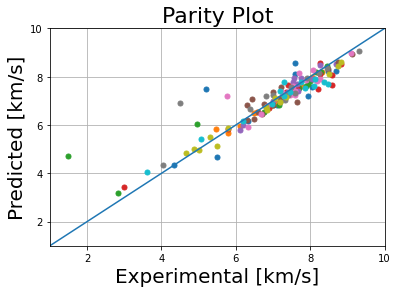

In [38]:
#test_preds = np.around(new_model.predict([test_inputs[:, 0], test_inputs[:, 1], test_inputs[:, 2], test_inputs[:, 3]]),decimals=3)
#train_preds = np.around(new_model.predict([train_inputs[:, 0], train_inputs[:, 1], train_inputs[:, 2], train_inputs[:, 3]]),decimals=3)

#preds = np.around(new_model.predict([inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3]]),decimals=3)

for i in range(len(test_outputs_list)):
   # plt.plot(train_outputs_list[i], train_preds_list[i], 'o')
    plt.plot(test_outputs_list[i], test_preds_list[i], 'o', markersize=5)

#plt.plot(df['D (exp) [km/s]'], df['D_KJ [km/s]'], 'o')

plt.xlabel('Experimental [km/s]', fontsize=20)
plt.ylabel('Predicted [km/s]', fontsize=20)
plt.title('Parity Plot', fontsize=22)

x = np.linspace(1, 10, 500)
plt.plot(x, x)
plt.ylim(1.0,10)
plt.xlim(1.0,10)

plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels


plt.grid()

In [21]:
len(test_outputs_list)

10

In [41]:
df['D_diff'] = abs(df['D (exp) [km/s]']-df['D_KJ'])
worst = df[['Explosive','D_diff','D (exp) [km/s]','D_KJ']].sort_values(by='D_diff')[-4:].reset_index(drop=True)

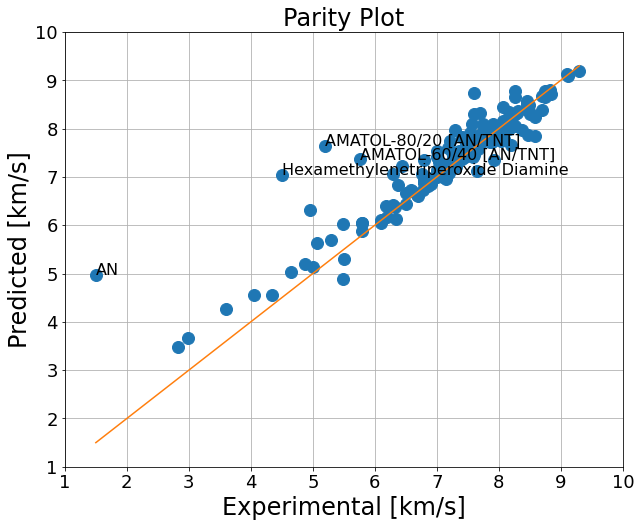

In [47]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

x = np.linspace(min(df['D (exp) [km/s]']), max(df['D (exp) [km/s]']), 500)
plt.plot(df['D (exp) [km/s]'], df['D_KJ'], 'o', markersize=12.0)
plt.plot(x, x)

for i in range(len(worst)):                                       # <--
    ax.annotate(str(worst['Explosive'][i]), xy=(worst['D (exp) [km/s]'][i], worst['D_KJ'][i]), fontsize=16) # <--

ax.set_xlabel('Experimental [km/s]', fontsize=24)
ax.set_ylabel('Predicted [km/s]', fontsize=24)
ax.set_title('Parity Plot', fontsize=24)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

plt.ylim(1,10)
plt.xlim(1,10)
plt.grid()

In [ ]:
df['D (exp) [km/s]'].mean()

In [43]:
rms = np.sqrt(mean_squared_error(df['D (exp) [km/s]'], df['D_KJ']))

In [44]:
rms

0.5333311804830856

In [ ]:
test_preds

In [ ]:
new_model, trainable = create_model(individual)
#train(new_model, inputs, outputs, verbose=False)

In [ ]:
new_model.get_weights()

In [ ]:
wtbs_default = 20*[np.array([[0]]),np.array([0])]

In [55]:
individual = [0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2] # p.01
new_model, trainable = create_model(individual)
new_model.summary()

Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_241 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_242 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_243 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_244 (InputLayer)          (None, 1)            0                                            
___________________________________________________________________________________________

In [7]:
#df[df[['Al','B','Ba','Ca','Cl','F','P','Pb','Si']] == 0]

chno = df[(df.Al == 0) & (df.B == 0) & (df.Ba == 0) & (df.Ca == 0) & (df.Cl == 0) & (df.F == 0) & (df.P == 0) & (df.Pb == 0) & (df.Si == 0)].reset_index(drop=True)

In [11]:
chno.to_csv('CHNO_data.csv', index=False)